In [3]:
# CELL 1: Setup
import pandas as pd
from pathlib import Path
import nibabel as nib
import numpy as np
from scipy.ndimage import label, center_of_mass
from scipy.stats import pearsonr, ttest_ind

CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
RESULTS_CSV = '/user_data/csimmon2/git_repos/long_pt/B_analyses/results.csv'
OUTPUT_CSV = '/user_data/csimmon2/git_repos/long_pt/B_analyses/results_final.csv'

df = pd.read_csv(CSV_FILE)

BASE_DIR = Path("/user_data/csimmon2/long_pt")
SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}

COPE_MAP_DIFFERENTIAL = {
    'face': (10, 1),
    'word': (13, -1),
    'object': (3, 1),
    'house': (11, 1)
}

COPE_MAP_SCRAMBLE = {
    'face': (10, 1),
    'word': (12, 1),
    'object': (3, 1),
    'house': (11, 1)
}

def create_sphere(center_coord, affine, brain_shape, radius=6):
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]),
        np.arange(brain_shape[1]),
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - center_coord, axis=1)
    
    mask_3d = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        mask_3d[coord[0], coord[1], coord[2]] = True
    
    return mask_3d

print("✓ Cell 1 complete")

✓ Cell 1 complete


In [4]:
# CELL 2: Load Subjects
def load_subjects_by_group(group_filter=None, patient_only=True):
    filtered_df = df.copy()
    
    if patient_only is True:
        filtered_df = filtered_df[filtered_df['patient'] == 1]
    elif patient_only is False:
        filtered_df = filtered_df[filtered_df['patient'] == 0]
    
    if group_filter:
        if isinstance(group_filter, str):
            group_filter = [group_filter]
        filtered_df = filtered_df[filtered_df['group'].isin(group_filter)]
    
    subjects = {}
    for _, row in filtered_df.iterrows():
        subject_id = row['sub']
        subj_dir = BASE_DIR / subject_id
        if not subj_dir.exists():
            continue
        
        sessions = sorted([d.name.replace('ses-', '') for d in subj_dir.glob('ses-*') if d.is_dir()], key=int)
        start_session = SESSION_START.get(subject_id, 1)
        sessions = [s for s in sessions if int(s) >= start_session]
        if not sessions:
            continue
        
        hemisphere = 'l' if row.get('intact_hemi', 'left') == 'left' else 'r'
        
        subjects[subject_id] = {
            'code': f"{row['group']}{subject_id.split('-')[1]}",
            'sessions': sessions,
            'hemi': hemisphere,
            'group': row['group'],
            'patient_status': 'patient' if row['patient'] == 1 else 'control',
            'surgery_side': row.get('SurgerySide', None)
        }
    return subjects

ALL_PATIENTS = load_subjects_by_group(patient_only=True)
ALL_CONTROLS = load_subjects_by_group(patient_only=False)
ANALYSIS_SUBJECTS = {**ALL_PATIENTS, **ALL_CONTROLS}

print(f"✓ Loaded {len(ANALYSIS_SUBJECTS)} subjects")
for g in ['OTC', 'nonOTC', 'control']:
    n = sum(1 for v in ANALYSIS_SUBJECTS.values() if v['group'] == g)
    print(f"  {g}: {n}")

✓ Loaded 25 subjects
  OTC: 7
  nonOTC: 9
  control: 9


In [9]:
# CELL 3: EXTRACTION - Top 20% ROI Extraction (Both Contrast Sets)
# ============================================================

def extract_top20_rois(subject_id, cope_map, percentile=80, min_cluster_size=20):
    """Extract ROIs using top 20% of voxels within search mask"""
    
    info = ANALYSIS_SUBJECTS[subject_id]
    roi_dir = BASE_DIR / subject_id / f'ses-{info["sessions"][0]}' / 'ROIs'
    if not roi_dir.exists(): 
        return {}
    
    all_results = {}
    first_session = info['sessions'][0]

    for hemi in ['l', 'r']:
        for category, (cope_num, multiplier) in cope_map.items():
            
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            if not mask_file.exists(): 
                continue
            
            try:
                search_mask_img = nib.load(mask_file)
                search_mask = search_mask_img.get_fdata() > 0
                affine = search_mask_img.affine
            except: 
                continue
            
            hemi_key = f'{hemi}_{category}'
            all_results[hemi_key] = {}
            
            for session in info['sessions']:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists(): 
                    continue
                
                try:
                    z_full = nib.load(cope_file).get_fdata() * multiplier
                    pos_voxels = z_full[search_mask & (z_full > 0)]
                    
                    if len(pos_voxels) < min_cluster_size: 
                        continue
                    
                    dynamic_thresh = max(np.percentile(pos_voxels, percentile), 1.64)
                    
                    suprathresh = (z_full > dynamic_thresh) & search_mask
                    labeled, n_clusters = label(suprathresh)
                    
                    if n_clusters == 0: 
                        continue
                    
                    # Select largest cluster
                    best_idx, max_size = -1, 0
                    for i in range(1, n_clusters + 1):
                        size = np.sum(labeled == i)
                        if size > max_size:
                            max_size = size
                            best_idx = i
                    
                    if best_idx == -1 or max_size < min_cluster_size: 
                        continue
                    
                    roi_mask = (labeled == best_idx)
                    peak_idx = np.unravel_index(np.argmax(z_full * roi_mask), z_full.shape)
                    
                    all_results[hemi_key][session] = {
                        'n_voxels': int(np.sum(roi_mask)),
                        'peak_z': z_full[peak_idx],
                        'centroid': nib.affines.apply_affine(affine, center_of_mass(roi_mask)),
                        'threshold': dynamic_thresh
                    }
                except Exception as e:
                    print(f"Error {subject_id} {hemi_key} ses-{session}: {e}")
                    
    return all_results

# Extract for BOTH contrast sets
print("Extracting Top 20% ROIs - DIFFERENTIAL...")
top20_differential = {}
for sub in ANALYSIS_SUBJECTS:
    res = extract_top20_rois(sub, COPE_MAP_DIFFERENTIAL)
    if res: 
        top20_differential[sub] = res
print(f"✓ Differential: {len(top20_differential)} subjects")

print("\nExtracting Top 20% ROIs - SCRAMBLE...")
top20_scramble = {}
for sub in ANALYSIS_SUBJECTS:
    res = extract_top20_rois(sub, COPE_MAP_SCRAMBLE)
    if res: 
        top20_scramble[sub] = res
print(f"✓ Scramble: {len(top20_scramble)} subjects")

Extracting Top 20% ROIs - DIFFERENTIAL...
✓ Differential: 24 subjects

Extracting Top 20% ROIs - SCRAMBLE...
✓ Scramble: 24 subjects


In [10]:
# CELL 4: SPATIAL RELOCATION (Drift) - Both Contrast Sets
# ============================================================

def compute_spatial_relocation(functional_results, subjects_dict):
    """
    Compute Spatial Relocation (Drift)
    - Euclidean distance between T1 and T2 centroids
    - Higher values = more physical movement
    """
    
    results = []
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            c1 = sessions_data[sessions[0]]['centroid']
            c2 = sessions_data[sessions[-1]]['centroid']
            drift = np.linalg.norm(np.array(c2) - np.array(c1))
            
            # Flag weak signal (T1 peak z < 2.3)
            t1_z = sessions_data[sessions[0]]['peak_z']
            flag = 'WEAK_SIGNAL' if t1_z < 2.3 else ''
            
            hemi = roi_key.split('_')[0]
            category = roi_key.split('_')[1]
            
            results.append({
                'subject': sid,
                'code': info.get('code', sid),
                'group': info.get('group', 'unknown'),
                'hemi': hemi,
                'category': category,
                'category_type': 'Bilateral' if category in ['object', 'house'] else 'Unilateral',
                'spatial_relocation_mm': drift,
                'flag': flag
            })
    
    return pd.DataFrame(results)

# Compute for both contrast sets
print("Computing Spatial Relocation...")
drift_differential = compute_spatial_relocation(top20_differential, ANALYSIS_SUBJECTS)
drift_scramble = compute_spatial_relocation(top20_scramble, ANALYSIS_SUBJECTS)

print(f"\nDIFFERENTIAL Summary:")
print(drift_differential.groupby(['group', 'category_type'])['spatial_relocation_mm'].agg(['mean', 'std', 'count']))

print(f"\nSCRAMBLE Summary (for supplementary):")
print(drift_scramble.groupby(['group', 'category_type'])['spatial_relocation_mm'].agg(['mean', 'std', 'count']))

Computing Spatial Relocation...

DIFFERENTIAL Summary:
                            mean        std  count
group   category_type                             
OTC     Bilateral       6.951114   5.838820     12
        Unilateral     12.486170  12.437719     12
control Bilateral       5.441073   7.067455     36
        Unilateral      5.784939   8.114254     36
nonOTC  Bilateral       3.418780   2.262256     18
        Unilateral      5.244716   6.506233     18

SCRAMBLE Summary (for supplementary):
                            mean        std  count
group   category_type                             
OTC     Bilateral       6.951114   5.838820     12
        Unilateral     15.115700  14.963761     12
control Bilateral       5.441073   7.067455     36
        Unilateral      6.628637   7.938228     36
nonOTC  Bilateral       3.418780   2.262256     18
        Unilateral      6.820326  11.128870     18


In [21]:
# CELL: SPATIAL DRIFT - Peak-Based (Golarai Method) - Plaut
# ============================================================
# Following Golarai et al. (2015): Track peak voxel location across sessions
# Drift = Euclidean distance between T1 and T2 peak coordinates (mm)
# ============================================================

EXCLUDE_SUBS = ['sub-025', 'sub-027', 'sub-045', 'sub-072']

def extract_peak_locations(subject_id, cope_map):
    """Extract peak voxel (max T-value) locations within search mask for each session"""
    
    info = ANALYSIS_SUBJECTS[subject_id]
    roi_dir = BASE_DIR / subject_id / f'ses-{info["sessions"][0]}' / 'ROIs'
    if not roi_dir.exists(): 
        return {}
    
    all_results = {}
    first_session = info['sessions'][0]

    for hemi in ['l', 'r']:
        for category, (cope_num, multiplier) in cope_map.items():
            
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            if not mask_file.exists(): 
                continue
            
            try:
                search_mask_img = nib.load(mask_file)
                search_mask = search_mask_img.get_fdata() > 0
                affine = search_mask_img.affine
            except: 
                continue
            
            hemi_key = f'{hemi}_{category}'
            all_results[hemi_key] = {}
            
            for session in info['sessions']:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists(): 
                    continue
                
                try:
                    z_data = nib.load(cope_file).get_fdata() * multiplier
                    z_masked = np.where(search_mask & (z_data > 0), z_data, -np.inf)
                    peak_idx = np.unravel_index(np.argmax(z_masked), z_masked.shape)
                    peak_z = z_data[peak_idx]
                    
                    if peak_z <= 0:
                        continue
                    
                    peak_mni = nib.affines.apply_affine(affine, peak_idx)
                    
                    all_results[hemi_key][session] = {
                        'peak_idx': peak_idx,
                        'peak_mni': peak_mni,
                        'peak_z': peak_z
                    }
                except Exception as e:
                    print(f"Error {subject_id} {hemi_key} ses-{session}: {e}")
                    
    return all_results


def compute_peak_drift(peak_results, subjects_dict):
    """Compute Euclidean distance between T1 and T2 peak locations (mm)"""
    
    results = []
    
    for sid, rois in peak_results.items():
        if sid in EXCLUDE_SUBS:
            continue
        info = subjects_dict.get(sid, {})
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            peak_t1 = np.array(sessions_data[sessions[0]]['peak_mni'])
            peak_t2 = np.array(sessions_data[sessions[-1]]['peak_mni'])
            drift_mm = np.linalg.norm(peak_t2 - peak_t1)
            
            t1_z = sessions_data[sessions[0]]['peak_z']
            hemi = roi_key.split('_')[0]
            category = roi_key.split('_')[1]
            
            results.append({
                'subject': sid,
                'code': subjects_dict[sid].get('code', sid),
                'group': subjects_dict[sid].get('group', 'unknown'),
                'hemi': hemi,
                'category': category,
                'category_type': 'Bilateral' if category in ['object', 'house'] else 'Unilateral',
                'peak_drift_mm': drift_mm,
                't1_peak_z': t1_z,
                't2_peak_z': sessions_data[sessions[-1]]['peak_z'],
                'flag': 'WEAK_SIGNAL' if t1_z < 2.3 else ''
            })
    
    return pd.DataFrame(results)


# Run extraction
print("Extracting Peak Locations (Golarai method)...")
peak_locations = {}
for sub in ANALYSIS_SUBJECTS:
    if sub not in EXCLUDE_SUBS:
        res = extract_peak_locations(sub, COPE_MAP_DIFFERENTIAL)
        if res: 
            peak_locations[sub] = res

print("Computing Peak-Based Drift...")
drift_peak = compute_peak_drift(peak_locations, ANALYSIS_SUBJECTS)

# Add hemisphere info
drift_peak['intact_hemi'] = drift_peak['subject'].map(lambda s: ANALYSIS_SUBJECTS[s]['hemi'])

print(f"\n✓ {drift_peak['subject'].nunique()} subjects, {len(drift_peak)} measurements")
print(f"  Excluded: {EXCLUDE_SUBS}")

# Save
drift_peak.to_csv('drift_peak_golarai.csv', index=False)
print("✓ Saved to drift_peak_golarai.csv")

Extracting Peak Locations (Golarai method)...
Computing Peak-Based Drift...

✓ 20 subjects, 108 measurements
  Excluded: ['sub-025', 'sub-027', 'sub-045', 'sub-072']
✓ Saved to drift_peak_golarai.csv


In [22]:
# CELL: SPATIAL DRIFT - Descriptives and Statistical Tests
# ============================================================
# Hemisphere selection:
#   OTC: intact hemisphere
#   nonOTC: intact hemisphere
#   Controls: face=R, word=L, object/house=both
# ============================================================
from scipy.stats import ttest_ind, f_oneway

df = drift_peak.copy()

# Filter by appropriate hemisphere
otc = df[(df['group'] == 'OTC') & (df['hemi'] == df['intact_hemi'])]
nonotc = df[(df['group'] == 'nonOTC') & (df['hemi'] == df['intact_hemi'])]
ctrl = df[df['group'] == 'control']

# Control subsets by category
ctrl_face = ctrl[(ctrl['category'] == 'face') & (ctrl['hemi'] == 'r')]
ctrl_word = ctrl[(ctrl['category'] == 'word') & (ctrl['hemi'] == 'l')]
ctrl_object = ctrl[ctrl['category'] == 'object']
ctrl_house = ctrl[ctrl['category'] == 'house']

ctrl_by_cat = {'face': ctrl_face, 'word': ctrl_word, 'object': ctrl_object, 'house': ctrl_house}

# ============================================================
# DESCRIPTIVES BY CATEGORY
# ============================================================
print("="*85)
print("SPATIAL DRIFT BY CATEGORY")
print("="*85)
print(f"\n{'Category':<10} {'Type':<8} {'OTC-intact':<22} {'nonOTC-intact':<22} {'Control':<22}")
print("-"*85)

for cat in ['face', 'word', 'object', 'house']:
    otc_vals = otc[otc['category'] == cat]['peak_drift_mm']
    nonotc_vals = nonotc[nonotc['category'] == cat]['peak_drift_mm']
    ctrl_vals = ctrl_by_cat[cat]['peak_drift_mm']
    
    cat_type = "Uni" if cat in ['face', 'word'] else "Bil"
    
    otc_str = f"{otc_vals.mean():.1f} ± {otc_vals.std():.1f} [n={len(otc_vals)}]"
    nonotc_str = f"{nonotc_vals.mean():.1f} ± {nonotc_vals.std():.1f} [n={len(nonotc_vals)}]"
    ctrl_str = f"{ctrl_vals.mean():.1f} ± {ctrl_vals.std():.1f} [n={len(ctrl_vals)}]"
    
    print(f"{cat:<10} {cat_type:<8} {otc_str:<22} {nonotc_str:<22} {ctrl_str:<22}")

print("-"*85)

# ============================================================
# DESCRIPTIVES BY CATEGORY TYPE
# ============================================================
print("\n" + "="*85)
print("SPATIAL DRIFT BY CATEGORY TYPE")
print("="*85)

otc_uni = otc[otc['category'].isin(['face', 'word'])]['peak_drift_mm']
otc_bil = otc[otc['category'].isin(['object', 'house'])]['peak_drift_mm']
nonotc_uni = nonotc[nonotc['category'].isin(['face', 'word'])]['peak_drift_mm']
nonotc_bil = nonotc[nonotc['category'].isin(['object', 'house'])]['peak_drift_mm']
ctrl_uni = pd.concat([ctrl_face['peak_drift_mm'], ctrl_word['peak_drift_mm']])
ctrl_bil = pd.concat([ctrl_object['peak_drift_mm'], ctrl_house['peak_drift_mm']])

print(f"\n{'Type':<12} {'OTC-intact':<22} {'nonOTC-intact':<22} {'Control':<22}")
print("-"*85)
print(f"{'Unilateral':<12} {otc_uni.mean():.1f} ± {otc_uni.std():.1f} [n={len(otc_uni)}]{'':5} {nonotc_uni.mean():.1f} ± {nonotc_uni.std():.1f} [n={len(nonotc_uni)}]{'':5} {ctrl_uni.mean():.1f} ± {ctrl_uni.std():.1f} [n={len(ctrl_uni)}]")
print(f"{'Bilateral':<12} {otc_bil.mean():.1f} ± {otc_bil.std():.1f} [n={len(otc_bil)}]{'':5} {nonotc_bil.mean():.1f} ± {nonotc_bil.std():.1f} [n={len(nonotc_bil)}]{'':5} {ctrl_bil.mean():.1f} ± {ctrl_bil.std():.1f} [n={len(ctrl_bil)}]")
print("-"*85)

# ============================================================
# STATISTICAL TESTS BY CATEGORY
# ============================================================
print("\n" + "="*85)
print("STATISTICAL TESTS BY CATEGORY (OTC vs Control)")
print("="*85)

for cat in ['face', 'word', 'object', 'house']:
    otc_vals = otc[otc['category'] == cat]['peak_drift_mm']
    ctrl_vals = ctrl_by_cat[cat]['peak_drift_mm']
    cat_type = "Uni" if cat in ['face', 'word'] else "Bil"
    
    if len(otc_vals) > 1 and len(ctrl_vals) > 1:
        t, p = ttest_ind(otc_vals, ctrl_vals)
        print(f"{cat} ({cat_type}): t = {t:.3f}, p = {p:.4f}")

# ============================================================
# STATISTICAL TESTS BY CATEGORY TYPE
# ============================================================
print("\n" + "="*85)
print("STATISTICAL TESTS BY CATEGORY TYPE")
print("="*85)

for type_name, otc_v, nonotc_v, ctrl_v in [
    ('Unilateral', otc_uni, nonotc_uni, ctrl_uni), 
    ('Bilateral', otc_bil, nonotc_bil, ctrl_bil)
]:
    print(f"\n{type_name}:")
    f, p = f_oneway(otc_v, nonotc_v, ctrl_v)
    print(f"  ANOVA (3 groups): F = {f:.3f}, p = {p:.4f}")
    t, p = ttest_ind(otc_v, ctrl_v)
    print(f"  OTC vs Control: t = {t:.3f}, p = {p:.4f}")
    t, p = ttest_ind(otc_v, nonotc_v)
    print(f"  OTC vs nonOTC: t = {t:.3f}, p = {p:.4f}")
    t, p = ttest_ind(nonotc_v, ctrl_v)
    print(f"  nonOTC vs Control: t = {t:.3f}, p = {p:.4f}")

print("\n" + "="*85)

SPATIAL DRIFT BY CATEGORY

Category   Type     OTC-intact             nonOTC-intact          Control               
-------------------------------------------------------------------------------------
face       Uni      6.6 ± 7.8 [n=6]        2.8 ± 5.0 [n=7]        1.4 ± 1.0 [n=7]       
word       Uni      13.7 ± 12.7 [n=6]      10.8 ± 8.1 [n=7]       14.2 ± 10.9 [n=7]     
object     Bil      5.2 ± 2.6 [n=6]        5.2 ± 6.8 [n=7]        9.1 ± 8.7 [n=14]      
house      Bil      15.4 ± 18.7 [n=6]      3.4 ± 2.3 [n=7]        9.7 ± 12.6 [n=14]     
-------------------------------------------------------------------------------------

SPATIAL DRIFT BY CATEGORY TYPE

Type         OTC-intact             nonOTC-intact          Control               
-------------------------------------------------------------------------------------
Unilateral   10.1 ± 10.7 [n=12]      6.8 ± 7.7 [n=14]      7.8 ± 10.0 [n=14]
Bilateral    10.3 ± 13.8 [n=12]      4.3 ± 5.0 [n=14]      9.4 ± 10.7 [n=28]
-

In [25]:
# CELL 5: GEOMETRY PRESERVATION - RDM Stability (6mm, 8mm, 10mm spheres)
# ============================================================

def compute_geometry_preservation(functional_results, cope_map, subjects_dict, radius=6):
    """
    Compute Geometry Preservation (RDM Stability)
    - Dynamic sphere at each session's centroid
    - Correlation of 4-category RDM between T1 and T2
    - Lower values = more representational change
    """
    
    results = []
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        if not info:
            continue
        
        first_session = info['sessions'][0]
        
        # Get reference image
        roi_dir = BASE_DIR / sid / f'ses-{first_session}' / 'ROIs'
        ref_file = None
        for cat in ['face', 'object', 'house', 'word']:
            for h in ['l', 'r']:
                test_file = roi_dir / f"{h}_{cat}_searchmask.nii.gz"
                if test_file.exists():
                    ref_file = test_file
                    break
            if ref_file:
                break
        
        if not ref_file:
            continue
            
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            first_ses, last_ses = sessions[0], sessions[-1]
            
            # Dynamic spheres at each session's centroid
            sphere_t1 = create_sphere(sessions_data[first_ses]['centroid'], affine, brain_shape, radius)
            sphere_t2 = create_sphere(sessions_data[last_ses]['centroid'], affine, brain_shape, radius)
            
            rdms = {}
            for ses, sphere in [(first_ses, sphere_t1), (last_ses, sphere_t2)]:
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                
                patterns = []
                valid = True
                
                for cat in ['face', 'word', 'object', 'house']:
                    cope_num, mult = cope_map[cat]
                    z_name = 'zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_session}.nii.gz'
                    cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                    
                    if not cope_file.exists():
                        valid = False
                        break
                    
                    data = nib.load(cope_file).get_fdata() * mult
                    pattern = data[sphere]
                    
                    if len(pattern) == 0 or not np.all(np.isfinite(pattern)):
                        valid = False
                        break
                    
                    patterns.append(pattern)
                
                if not valid or len(patterns) != 4:
                    continue
                
                try:
                    rdm = 1 - np.corrcoef(patterns)
                    rdms[ses] = rdm
                except:
                    continue
            
            if len(rdms) == 2:
                triu_idx = np.triu_indices(4, k=1)
                r, _ = pearsonr(rdms[first_ses][triu_idx], rdms[last_ses][triu_idx])
                
                hemi = roi_key.split('_')[0]
                category = roi_key.split('_')[1]
                
                results.append({
                    'subject': sid,
                    'code': info.get('code', sid),
                    'group': info.get('group', 'unknown'),
                    'hemi': hemi,
                    'category': category,
                    'category_type': 'Bilateral' if category in ['object', 'house'] else 'Unilateral',
                    'geometry_preservation': r
                })
    
    return pd.DataFrame(results)

# Compute for 6mm, 8mm, 10mm
print("Computing Geometry Preservation...")
geometry_results = {}
for radius in [6, 8, 10]:
    geometry_results[radius] = compute_geometry_preservation(
        top20_differential, COPE_MAP_DIFFERENTIAL, ANALYSIS_SUBJECTS, radius
    )
    print(f"  {radius}mm: {len(geometry_results[radius])} ROIs")
print("✓ Done")

Computing Geometry Preservation...
  6mm: 132 ROIs
  8mm: 132 ROIs
  10mm: 132 ROIs
✓ Done


In [26]:
# CELL 6: ANCHORED STABILITY - Pattern at Fixed T1 Location
# ============================================================

def compute_anchored_stability(functional_results, cope_map, subjects_dict, radius=6):
    """
    Compute Anchored Stability
    - Sphere at T1 centroid ONLY (anchored/fixed location)
    - Pattern correlation T1↔T2 at same location
    - Low values in OTC indicate functional region has relocated
    """
    
    results = []
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        if not info:
            continue
        
        first_session = info['sessions'][0]
        
        # Get reference image
        roi_dir = BASE_DIR / sid / f'ses-{first_session}' / 'ROIs'
        ref_file = None
        for cat in ['face', 'object', 'house', 'word']:
            for h in ['l', 'r']:
                test_file = roi_dir / f"{h}_{cat}_searchmask.nii.gz"
                if test_file.exists():
                    ref_file = test_file
                    break
            if ref_file:
                break
        
        if not ref_file:
            continue
            
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            first_ses, last_ses = sessions[0], sessions[-1]
            
            # ANCHORED: sphere at T1 centroid only
            sphere = create_sphere(sessions_data[first_ses]['centroid'], affine, brain_shape, radius)
            
            category = roi_key.split('_')[1]
            cope_num, mult = cope_map[category]
            
            patterns = {}
            for ses in [first_ses, last_ses]:
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists():
                    continue
                
                data = nib.load(cope_file).get_fdata() * mult
                pattern = data[sphere]
                
                if len(pattern) > 0 and np.all(np.isfinite(pattern)):
                    patterns[ses] = pattern
            
            if len(patterns) == 2:
                try:
                    r, _ = pearsonr(patterns[first_ses], patterns[last_ses])
                    
                    hemi = roi_key.split('_')[0]
                    
                    results.append({
                        'subject': sid,
                        'code': info.get('code', sid),
                        'group': info.get('group', 'unknown'),
                        'hemi': hemi,
                        'category': category,
                        'category_type': 'Bilateral' if category in ['object', 'house'] else 'Unilateral',
                        'anchored_stability': r
                    })
                except:
                    continue
    
    return pd.DataFrame(results)

# Compute
print("Computing Anchored Stability (6mm)...")
anchored_results = compute_anchored_stability(
    top20_differential, COPE_MAP_DIFFERENTIAL, ANALYSIS_SUBJECTS, radius=6
)
print(f"✓ Done: {len(anchored_results)} ROIs")

Computing Anchored Stability (6mm)...
✓ Done: 132 ROIs


In [7]:
# CELL 7: STATISTICS SUMMARY - All Measures
# ============================================================

def print_summary(df, measure_col, measure_name, higher_means_more_change=True):
    """Print summary statistics for a measure"""
    
    direction = "higher=more change" if higher_means_more_change else "lower=more change"
    print(f"\n{measure_name} ({direction})")
    print("-" * 70)
    
    for group in ['OTC', 'nonOTC', 'control']:
        group_data = df[df['group'] == group]
        bil = group_data[group_data['category_type'] == 'Bilateral'][measure_col]
        uni = group_data[group_data['category_type'] == 'Unilateral'][measure_col]
        
        if len(bil) > 1 and len(uni) > 1:
            t, p = ttest_ind(bil, uni)
            gap = bil.mean() - uni.mean()
            
            # Determine if supports hypothesis (bilateral > change in OTC)
            if higher_means_more_change:
                supports = "✓" if (gap > 0 and group == 'OTC' and p < 0.05) else ""
            else:
                supports = "✓" if (gap < 0 and group == 'OTC' and p < 0.05) else ""
            
            print(f"  {group:<8}: Bil={bil.mean():.3f}±{bil.sem():.3f} (n={len(bil)}), "
                  f"Uni={uni.mean():.3f}±{uni.sem():.3f} (n={len(uni)}), "
                  f"Gap={gap:+.3f}, p={p:.4f} {supports}")

print("="*70)
print("RESULTS SUMMARY - All Measures")
print("="*70)

# Spatial Relocation (higher = more movement)
print_summary(drift_differential, 'spatial_relocation_mm', 
              'SPATIAL RELOCATION (mm)', higher_means_more_change=True)

# Geometry Preservation (lower = more change)
print_summary(geometry_results[6], 'geometry_preservation', 
              'GEOMETRY PRESERVATION (6mm)', higher_means_more_change=False)

# Anchored Stability (lower = region moved away from anchor)
print_summary(anchored_results, 'anchored_stability',
              'ANCHORED STABILITY (6mm)', higher_means_more_change=False)

print("\n" + "="*70)
print("NOTE: Selectivity Change (Liu) computed separately - see results.csv")
print("="*70)

RESULTS SUMMARY - All Measures

SPATIAL RELOCATION (mm) (higher=more change)
----------------------------------------------------------------------
  OTC     : Bil=6.951±1.686 (n=12), Uni=12.486±3.590 (n=12), Gap=-5.535, p=0.1768 
  nonOTC  : Bil=3.419±0.533 (n=18), Uni=5.245±1.534 (n=18), Gap=-1.826, p=0.2686 
  control : Bil=5.441±1.178 (n=36), Uni=5.785±1.352 (n=36), Gap=-0.344, p=0.8485 

GEOMETRY PRESERVATION (6mm) (lower=more change)
----------------------------------------------------------------------
  OTC     : Bil=0.424±0.101 (n=12), Uni=0.713±0.057 (n=12), Gap=-0.289, p=0.0205 ✓
  nonOTC  : Bil=0.726±0.061 (n=18), Uni=0.762±0.046 (n=18), Gap=-0.036, p=0.6408 
  control : Bil=0.659±0.060 (n=36), Uni=0.755±0.035 (n=36), Gap=-0.096, p=0.1733 

ANCHORED STABILITY (6mm) (lower=more change)
----------------------------------------------------------------------
  OTC     : Bil=0.563±0.086 (n=12), Uni=0.352±0.128 (n=12), Gap=+0.211, p=0.1858 
  nonOTC  : Bil=0.884±0.016 (n=18), Uni

In [12]:
# CELL 8: MERGE AND SAVE CSV
# ============================================================

# Load original CSV
df = pd.read_csv(RESULTS_CSV)
print(f"Original CSV: {len(df)} rows")

# Rename existing columns to new naming scheme
rename_existing = {
    'Liu_Distinctiveness': 'Selectivity_Change',
    'RDM_Stability': 'Geometry_Preservation_old',
    'Hybrid_Stability': 'Anchored_Stability_old',
    'Spatial_Drift_mm': 'Spatial_Relocation_mm_old'
}
df = df.rename(columns={k: v for k, v in rename_existing.items() if k in df.columns})

# Create merge helper function
def get_merge_hemi(row):
    if pd.notna(row.get('nonpt_hemi')):
        return row['nonpt_hemi'].upper()
    elif pd.notna(row.get('Intact_Hemisphere')):
        return str(row['Intact_Hemisphere'])[0].upper()
    return None

df['merge_hemi'] = df.apply(get_merge_hemi, axis=1)

# --- Merge Spatial Relocation ---
drift_df = drift_differential.copy()
drift_df['merge_key'] = drift_df['code'] + '_' + drift_df['hemi'].str.upper() + '_' + drift_df['category'].str.capitalize()
df['merge_key'] = df['Subject'] + '_' + df['merge_hemi'] + '_' + df['Category']

drift_df = drift_df.rename(columns={'spatial_relocation_mm': 'Spatial_Relocation_mm'})
df = df.merge(drift_df[['merge_key', 'Spatial_Relocation_mm']], on='merge_key', how='left')
df = df.drop(columns=['merge_key'])
print(f"Spatial_Relocation_mm: {df['Spatial_Relocation_mm'].notna().sum()}/{len(df)} values")

# --- Merge Geometry Preservation (6mm, 8mm, 10mm) ---
for radius in [6, 8, 10]:
    geom_df = geometry_results[radius].copy()
    geom_df['merge_key'] = geom_df['code'] + '_' + geom_df['hemi'].str.upper() + '_' + geom_df['category'].str.capitalize()
    df['merge_key'] = df['Subject'] + '_' + df['merge_hemi'] + '_' + df['Category']
    
    col_name = f'Geometry_Preservation_{radius}mm'
    geom_df = geom_df.rename(columns={'geometry_preservation': col_name})
    
    df = df.merge(geom_df[['merge_key', col_name]], on='merge_key', how='left')
    df = df.drop(columns=['merge_key'])
    print(f"{col_name}: {df[col_name].notna().sum()}/{len(df)} values")

# --- Merge Anchored Stability (6mm) ---
anch_df = anchored_results.copy()
anch_df['merge_key'] = anch_df['code'] + '_' + anch_df['hemi'].str.upper() + '_' + anch_df['category'].str.capitalize()
df['merge_key'] = df['Subject'] + '_' + df['merge_hemi'] + '_' + df['Category']

anch_df = anch_df.rename(columns={'anchored_stability': 'Anchored_Stability_6mm'})
df = df.merge(anch_df[['merge_key', 'Anchored_Stability_6mm']], on='merge_key', how='left')
df = df.drop(columns=['merge_key', 'merge_hemi'])
print(f"Anchored_Stability_6mm: {df['Anchored_Stability_6mm'].notna().sum()}/{len(df)} values")

# Save
df.to_csv(OUTPUT_CSV, index=False)
print(f"\n✓ Saved to: {OUTPUT_CSV}")
print(f"Final shape: {df.shape}")

Original CSV: 132 rows
Spatial_Relocation_mm: 132/132 values
Geometry_Preservation_6mm: 132/132 values
Geometry_Preservation_8mm: 132/132 values
Geometry_Preservation_10mm: 132/132 values
Anchored_Stability_6mm: 132/132 values

✓ Saved to: /user_data/csimmon2/git_repos/long_pt/B_analyses/results_final.csv
Final shape: (132, 20)


In [23]:
# CELL 9: Final summary after clean re-run

print("="*70)
print("FINAL RESULTS SUMMARY (n=6 OTC)")
print("="*70)

df = pd.read_csv(OUTPUT_CSV)

measures = [
    ('Selectivity_Change', 'higher'),
    ('Geometry_Preservation_6mm', 'lower'),
    ('Anchored_Stability_6mm', 'lower'),
    ('Spatial_Relocation_mm', 'higher')
]

for measure, direction in measures:
    print(f"\n{measure} ({direction}=more change)")
    print("-"*50)
    
    for group in ['OTC', 'nonOTC', 'control']:
        grp = df[df['Group'] == group]
        bil = grp[grp['Category_Type'] == 'Bilateral'][measure].dropna()
        uni = grp[grp['Category_Type'] == 'Unilateral'][measure].dropna()
        
        if len(bil) > 1 and len(uni) > 1:
            t, p = ttest_ind(bil, uni)
            sig = '✓' if p < 0.05 else ''
            print(f"  {group:<8}: Bil={bil.mean():.3f}±{bil.sem():.3f} (n={len(bil)}), "
                  f"Uni={uni.mean():.3f}±{uni.sem():.3f} (n={len(uni)}), p={p:.4f} {sig}")

FINAL RESULTS SUMMARY (n=6 OTC)

Selectivity_Change (higher=more change)
--------------------------------------------------
  OTC     : Bil=0.419±0.078 (n=12), Uni=0.144±0.031 (n=12), p=0.0033 ✓
  nonOTC  : Bil=0.140±0.022 (n=18), Uni=0.131±0.032 (n=18), p=0.8314 
  control : Bil=0.259±0.028 (n=36), Uni=0.149±0.022 (n=36), p=0.0031 ✓

Geometry_Preservation_6mm (lower=more change)
--------------------------------------------------
  OTC     : Bil=0.424±0.101 (n=12), Uni=0.713±0.057 (n=12), p=0.0205 ✓
  nonOTC  : Bil=0.726±0.061 (n=18), Uni=0.762±0.046 (n=18), p=0.6408 
  control : Bil=0.659±0.060 (n=36), Uni=0.755±0.035 (n=36), p=0.1733 

Anchored_Stability_6mm (lower=more change)
--------------------------------------------------
  OTC     : Bil=0.563±0.086 (n=12), Uni=0.352±0.128 (n=12), p=0.1858 
  nonOTC  : Bil=0.884±0.016 (n=18), Uni=0.720±0.063 (n=18), p=0.0171 ✓
  control : Bil=0.733±0.032 (n=36), Uni=0.653±0.054 (n=36), p=0.2074 

Spatial_Relocation_mm (higher=more change)
-----

In [14]:
# CELL: Check if OTC008 Word changed spatial relocation

print("OTC008 WORD SPATIAL RELOCATION")
print("="*50)

# Check OTC008 Word value
otc008_word = drift_differential[(drift_differential['code'] == 'OTC008') & 
                                  (drift_differential['category'] == 'word')]
print(f"OTC008 Word drift: {otc008_word['spatial_relocation_mm'].values}")

# Compare with and without
otc_drift = drift_differential[drift_differential['group'] == 'OTC']
otc_uni = otc_drift[otc_drift['category_type'] == 'Unilateral']

print(f"\nOTC Unilateral drift values:")
for _, row in otc_uni.iterrows():
    print(f"  {row['code']} {row['category']}: {row['spatial_relocation_mm']:.2f}mm")

print(f"\nMean with OTC008 Word: {otc_uni['spatial_relocation_mm'].mean():.2f}mm")
print(f"Mean without OTC008 Word: {otc_uni[~((otc_uni['code'] == 'OTC008') & (otc_uni['category'] == 'word'))]['spatial_relocation_mm'].mean():.2f}mm")

OTC008 WORD SPATIAL RELOCATION
OTC008 Word drift: [2.07011483]

OTC Unilateral drift values:
  OTC004 face: 9.49mm
  OTC004 word: 41.40mm
  OTC008 face: 2.35mm
  OTC008 word: 2.07mm
  OTC010 face: 11.03mm
  OTC010 word: 16.08mm
  OTC017 face: 12.81mm
  OTC017 word: 30.73mm
  OTC021 face: 2.60mm
  OTC021 word: 4.82mm
  OTC079 face: 0.98mm
  OTC079 word: 15.48mm

Mean with OTC008 Word: 12.49mm
Mean without OTC008 Word: 13.43mm


Extracted 118 drift vectors
  OTC: 18
  nonOTC: 35
  Control: 65


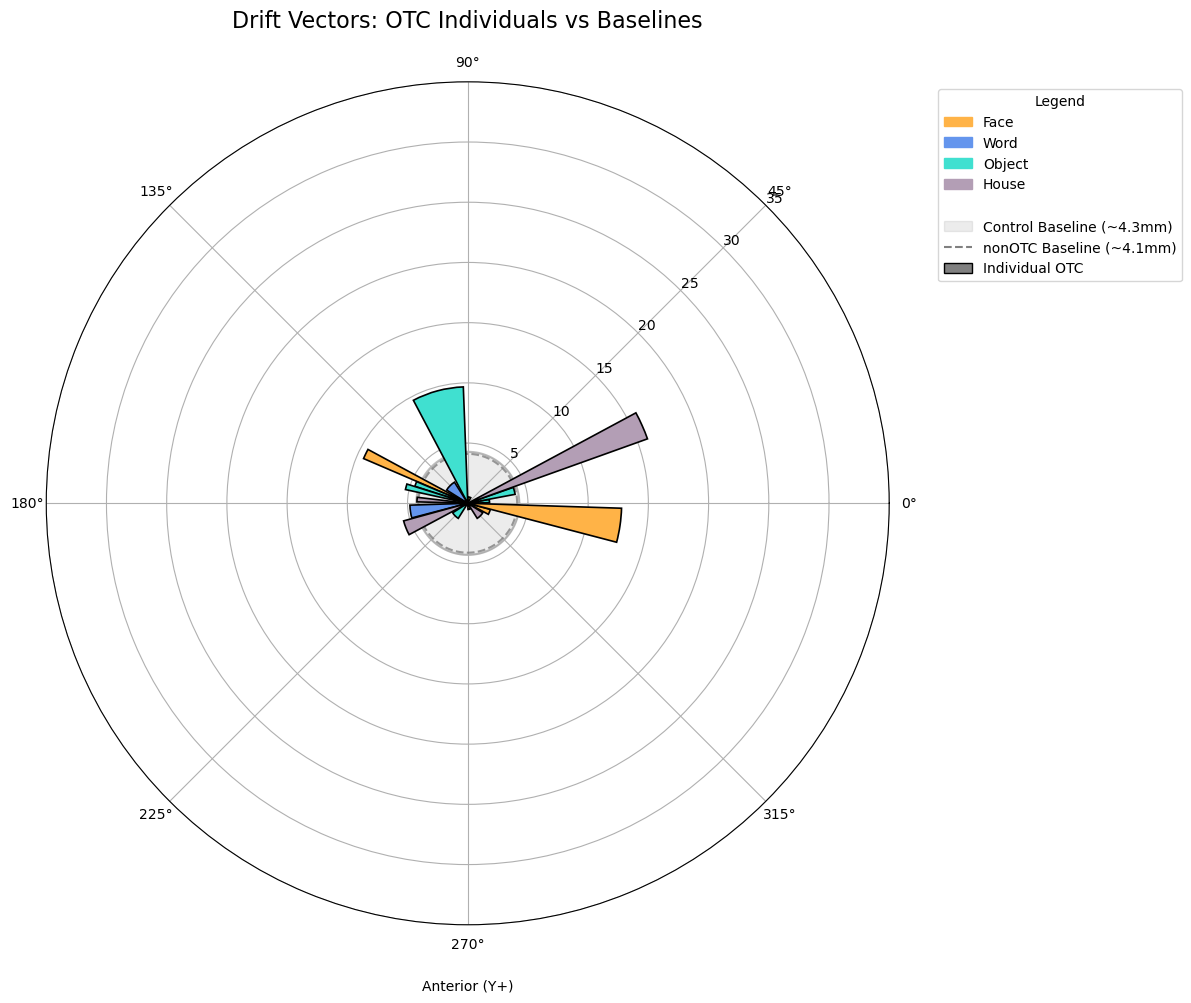

In [17]:
# CELL: Rose Plot (Updated for current pipeline)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- CONFIGURATION ---
BIN_FILL_RATIO = 0.9 

colors = {
    'face': '#FFB347',    # Pastel Peach
    'word': '#6495ED',    # Cornflower Blue
    'object': '#40E0D0',  # Turquoise
    'house': '#B39EB5'    # Pastel Purple
}
categories = ['face', 'word', 'object', 'house']

def cart2pol(y, z):
    return np.arctan2(z, y), np.sqrt(y**2 + z**2)

def get_bin_index(angle, bin_edges, n_bins):
    return min(np.digitize(angle, bin_edges) - 1, n_bins - 1)

def analyze_real_drift(results_dict, subjects_dict):
    data = []
    N_BINS = 12
    bin_edges = np.linspace(-np.pi, np.pi, N_BINS + 1)
    
    for sid, rois in results_dict.items():
        info = subjects_dict.get(sid, {})
        group = info.get('group', 'control')
        if info.get('patient_status') == 'control': 
            group = 'control'
        
        for roi_key, sessions in rois.items():
            cat = roi_key.split('_')[1]
            sorted_ses = sorted(sessions.keys())
            if len(sorted_ses) < 2: 
                continue
            
            s1 = sessions[sorted_ses[0]]
            s2 = sessions[sorted_ses[-1]]
            
            # Use threshold or peak_z for filtering
            t1 = s1.get('threshold', s1.get('peak_z', 0))
            t2 = s2.get('threshold', s2.get('peak_z', 0))
            if t1 < 1.65 or t2 < 1.65: 
                continue
            
            c1 = s1['centroid']
            c2 = s2['centroid']
            dy = c2[1] - c1[1]
            dz = c2[2] - c1[2]
            
            angle, radius = cart2pol(dy, dz)
            
            data.append({
                'Subject': sid, 'Group': group, 'Category': cat,
                'Radius': radius, 'Angle': angle,
                'Bin_Idx': get_bin_index(angle, bin_edges, N_BINS)
            })
            
    return pd.DataFrame(data)

def plot_dynamic_cluster_rose(df):
    N_BINS = 12
    bin_edges = np.linspace(-np.pi, np.pi, N_BINS + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    full_bin_width = (2 * np.pi) / N_BINS
    
    ctrl_mean = df[df['Group'] == 'control']['Radius'].mean()
    nonotc_mean = df[df['Group'] == 'nonOTC']['Radius'].mean()
    
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})
    ax.set_title("Drift Vectors: OTC Individuals vs Baselines", fontsize=16, pad=20)
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)
    ax.set_rlabel_position(45)
    ax.set_xlabel("Anterior (Y+)", labelpad=20)
    ax.set_ylim(0, 35)

    theta = np.linspace(0, 2*np.pi, 100)
    ax.fill_between(theta, 0, ctrl_mean, color='gray', alpha=0.15, zorder=0)
    ax.plot(theta, [ctrl_mean]*100, color='gray', linestyle='-', linewidth=1.5, alpha=0.5, zorder=1)
    ax.plot(theta, [nonotc_mean]*100, color='gray', linestyle='--', linewidth=1.5, alpha=0.8, zorder=2)

    for b_idx in range(N_BINS):
        bin_center = bin_centers[b_idx]
        items = df[(df['Group'] == 'OTC') & (df['Bin_Idx'] == b_idx)].copy()
        
        if not items.empty:
            items['Cat_Sort'] = pd.Categorical(items['Category'], categories=categories, ordered=True)
            items = items.sort_values(['Cat_Sort', 'Radius'])
            
            n_items = len(items)
            total_usable_width = full_bin_width * BIN_FILL_RATIO
            individual_bar_width = total_usable_width / n_items
            cluster_start = bin_center - (total_usable_width / 2) + (individual_bar_width / 2)
            
            for k, (_, row) in enumerate(items.iterrows()):
                theta = cluster_start + (k * individual_bar_width)
                ax.bar(theta, row['Radius'], width=individual_bar_width * 0.95, bottom=0.0,
                       color=colors[row['Category']], alpha=1.0, edgecolor='black', 
                       linewidth=1.2, zorder=10)

    legend_cats = [mpatches.Patch(color=c, label=cat.title()) for cat, c in colors.items()]
    style_legend = [
        mpatches.Patch(facecolor='gray', alpha=0.15, edgecolor='gray', label=f'Control Baseline (~{ctrl_mean:.1f}mm)'),
        plt.Line2D([0], [0], color='gray', linestyle='--', label=f'nonOTC Baseline (~{nonotc_mean:.1f}mm)'),
        mpatches.Patch(facecolor='gray', alpha=1.0, edgecolor='black', label='Individual OTC'),
    ]
    ax.legend(handles=legend_cats + [mpatches.Patch(visible=False)] + style_legend, 
              loc='upper left', bbox_to_anchor=(1.05, 1), title="Legend")
    plt.tight_layout()
    #plt.savefig('/user_data/csimmon2/git_repos/long_pt/B_analyses/figures/drift_rose_plot.png', 
    #            dpi=150, bbox_inches='tight')
    plt.show()

# --- EXECUTION ---
df_drift_real = analyze_real_drift(top20_differential, ANALYSIS_SUBJECTS)
print(f"Extracted {len(df_drift_real)} drift vectors")
print(f"  OTC: {len(df_drift_real[df_drift_real['Group'] == 'OTC'])}")
print(f"  nonOTC: {len(df_drift_real[df_drift_real['Group'] == 'nonOTC'])}")
print(f"  Control: {len(df_drift_real[df_drift_real['Group'] == 'control'])}")

plot_dynamic_cluster_rose(df_drift_real)

In [19]:
# CELL: COMPLETE FACT SHEET (n=6 OTC)

print("="*70)
print("COMPLETE FACT SHEET: ALL MEASURES (n=6 OTC)")
print("="*70)

df = pd.read_csv(OUTPUT_CSV)

# Define hemisphere-matched controls
ctrl_hemi = {'Face': 'R', 'Word': 'L', 'Object': 'R', 'House': 'R'}

# ============================================================
# SECTION 1: BILATERAL vs UNILATERAL by GROUP
# ============================================================

print("\n" + "="*70)
print("SECTION 1: BILATERAL vs UNILATERAL BY GROUP")
print("="*70)

measures = [
    ('Selectivity_Change', 'higher = more change'),
    ('Geometry_Preservation_6mm', 'lower = more change'),
    ('Anchored_Stability_6mm', 'lower = region relocated'),
    ('Spatial_Relocation_mm', 'higher = more movement')
]

for measure, interpretation in measures:
    if measure not in df.columns:
        continue
    
    print(f"\n{measure} ({interpretation})")
    print("-"*70)
    print(f"{'Group':<10} {'Bilateral':<25} {'Unilateral':<25} {'Gap':<10} {'p':<10}")
    
    for group in ['OTC', 'nonOTC', 'control']:
        if group == 'control':
            # Hemisphere-matched controls
            bil_vals = pd.concat([
                df[(df['Group'] == 'control') & (df['Category'] == 'Object') & (df['nonpt_hemi'] == 'R')][measure],
                df[(df['Group'] == 'control') & (df['Category'] == 'House') & (df['nonpt_hemi'] == 'R')][measure]
            ]).dropna()
            uni_vals = pd.concat([
                df[(df['Group'] == 'control') & (df['Category'] == 'Face') & (df['nonpt_hemi'] == 'R')][measure],
                df[(df['Group'] == 'control') & (df['Category'] == 'Word') & (df['nonpt_hemi'] == 'L')][measure]
            ]).dropna()
        else:
            grp = df[df['Group'] == group]
            bil_vals = grp[grp['Category_Type'] == 'Bilateral'][measure].dropna()
            uni_vals = grp[grp['Category_Type'] == 'Unilateral'][measure].dropna()
        
        if len(bil_vals) > 1 and len(uni_vals) > 1:
            t, p = ttest_ind(bil_vals, uni_vals)
            gap = bil_vals.mean() - uni_vals.mean()
            sig = '✓' if p < 0.05 else ''
            print(f"{group:<10} {bil_vals.mean():.3f}±{bil_vals.sem():.3f} (n={len(bil_vals):<2})  "
                  f"{uni_vals.mean():.3f}±{uni_vals.sem():.3f} (n={len(uni_vals):<2})  "
                  f"{gap:+.3f}     {p:.4f} {sig}")

# ============================================================
# SECTION 2: CATEGORY × GROUP
# ============================================================

print("\n" + "="*70)
print("SECTION 2: CATEGORY × GROUP")
print("="*70)
print("(Controls: Face=RH, Word=LH, Object/House=both hemispheres)")

for measure, interpretation in measures:
    if measure not in df.columns:
        continue
    
    print(f"\n{measure}")
    print("-"*70)
    print(f"{'Category':<10} {'OTC':<18} {'nonOTC':<18} {'Control':<18} {'OvN p':<10} {'OvC p':<10}")
    
    for cat in ['Face', 'Word', 'Object', 'House']:
        otc_vals = df[(df['Group'] == 'OTC') & (df['Category'] == cat)][measure].dropna()
        nonotc_vals = df[(df['Group'] == 'nonOTC') & (df['Category'] == cat)][measure].dropna()
        
        # Hemisphere-matched controls
        if cat == 'Face':
            ctrl_vals = df[(df['Group'] == 'control') & (df['Category'] == cat) & (df['nonpt_hemi'] == 'R')][measure].dropna()
        elif cat == 'Word':
            ctrl_vals = df[(df['Group'] == 'control') & (df['Category'] == cat) & (df['nonpt_hemi'] == 'L')][measure].dropna()
        else:
            ctrl_vals = df[(df['Group'] == 'control') & (df['Category'] == cat)][measure].dropna()
        
        # Stats
        p1_str = f"{ttest_ind(otc_vals, nonotc_vals)[1]:.3f}" if len(otc_vals) > 1 and len(nonotc_vals) > 1 else "---"
        p2_str = f"{ttest_ind(otc_vals, ctrl_vals)[1]:.3f}" if len(otc_vals) > 1 and len(ctrl_vals) > 1 else "---"
        
        otc_str = f"{otc_vals.mean():.3f}±{otc_vals.sem():.3f}" if len(otc_vals) > 0 else "---"
        nonotc_str = f"{nonotc_vals.mean():.3f}±{nonotc_vals.sem():.3f}" if len(nonotc_vals) > 0 else "---"
        ctrl_str = f"{ctrl_vals.mean():.3f}±{ctrl_vals.sem():.3f}" if len(ctrl_vals) > 0 else "---"
        
        print(f"{cat:<10} {otc_str:<18} {nonotc_str:<18} {ctrl_str:<18} {p1_str:<10} {p2_str:<10}")

# ============================================================
# SECTION 3: EFFECT DECOMPOSITION
# ============================================================

print("\n" + "="*70)
print("SECTION 3: WHAT DRIVES BILATERAL vs UNILATERAL?")
print("="*70)

for measure, interpretation in measures:
    if measure not in df.columns:
        continue
    
    print(f"\n{measure}:")
    
    otc = df[df['Group'] == 'OTC']
    
    obj_mean = otc[otc['Category'] == 'Object'][measure].dropna().mean()
    house_mean = otc[otc['Category'] == 'House'][measure].dropna().mean()
    face_mean = otc[otc['Category'] == 'Face'][measure].dropna().mean()
    word_mean = otc[otc['Category'] == 'Word'][measure].dropna().mean()
    
    uni_avg = (face_mean + word_mean) / 2
    
    print(f"  Bilateral:  Object={obj_mean:.3f}, House={house_mean:.3f}")
    print(f"  Unilateral: Face={face_mean:.3f}, Word={word_mean:.3f}")
    print(f"  Object vs Uni avg: {obj_mean - uni_avg:+.3f}")
    print(f"  House vs Uni avg:  {house_mean - uni_avg:+.3f}")

# ============================================================
# SECTION 4: SUMMARY TABLE
# ============================================================

print("\n" + "="*70)
print("SECTION 4: SUMMARY - HYPOTHESIS SUPPORT")
print("="*70)

print(f"\n{'Measure':<30} {'OTC Bil':<12} {'OTC Uni':<12} {'Gap':<10} {'p':<10} {'Supports?':<10}")
print("-"*80)

for measure, interpretation in measures:
    if measure not in df.columns:
        continue
    
    otc = df[df['Group'] == 'OTC']
    bil = otc[otc['Category_Type'] == 'Bilateral'][measure].dropna()
    uni = otc[otc['Category_Type'] == 'Unilateral'][measure].dropna()
    
    if len(bil) > 1 and len(uni) > 1:
        t, p = ttest_ind(bil, uni)
        gap = bil.mean() - uni.mean()
        
        # Determine if supports hypothesis
        if 'Selectivity' in measure or 'Relocation' in measure:
            supports = '✓' if (gap > 0 and p < 0.05) else '—'
        else:  # Geometry, Anchored (lower = more change)
            supports = '✓' if (gap < 0 and p < 0.05) else '—'
        
        print(f"{measure:<30} {bil.mean():<12.3f} {uni.mean():<12.3f} {gap:<+10.3f} {p:<10.4f} {supports}")

print("\n" + "="*70)
print("✓ FACT SHEET COMPLETE")
print("="*70)

COMPLETE FACT SHEET: ALL MEASURES (n=6 OTC)

SECTION 1: BILATERAL vs UNILATERAL BY GROUP

Selectivity_Change (higher = more change)
----------------------------------------------------------------------
Group      Bilateral                 Unilateral                Gap        p         
OTC        0.419±0.078 (n=12)  0.144±0.031 (n=12)  +0.275     0.0033 ✓
nonOTC     0.140±0.022 (n=18)  0.131±0.032 (n=18)  +0.008     0.8314 
control    0.243±0.037 (n=18)  0.116±0.028 (n=18)  +0.127     0.0101 ✓

Geometry_Preservation_6mm (lower = more change)
----------------------------------------------------------------------
Group      Bilateral                 Unilateral                Gap        p         
OTC        0.424±0.101 (n=12)  0.713±0.057 (n=12)  -0.289     0.0205 ✓
nonOTC     0.726±0.061 (n=18)  0.762±0.046 (n=18)  -0.036     0.6408 
control    0.729±0.068 (n=18)  0.786±0.044 (n=18)  -0.057     0.4857 

Anchored_Stability_6mm (lower = region relocated)
---------------------------------

In [2]:
# CELL: Generate all key figures (FIXED with pastel colors)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

df = pd.read_csv(OUTPUT_CSV)
FIGURE_DIR = '/user_data/csimmon2/git_repos/long_pt/B_analyses/figures'
import os
os.makedirs(FIGURE_DIR, exist_ok=True)

# Pastel color scheme
colors_group = {
    'OTC': '#ff9b83',      # Salmon
    'nonOTC': '#4ac0c0',   # Teal
    'control': '#9467bd'   # Muted Purple
}

colors_cat = {
    'Face': '#ff9b83',     # Salmon
    'Word': '#4ac0c0',     # Teal
    'Object': '#9467bd',   # Muted Purple
    'House': '#ffce56'     # Soft Gold
}

colors_type = {
    'Bilateral': '#ff9b83',   # Salmon
    'Unilateral': '#4ac0c0'   # Teal
}

# ============================================================
# FIGURE 1: Main Effect - Bilateral vs Unilateral by Group
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, (measure, ylabel, title) in enumerate([
    ('Selectivity_Change', 'Selectivity Change', 'Selectivity Change\n(higher = more change)'),
    ('Geometry_Preservation_6mm', 'Geometry Preservation (r)', 'Geometry Preservation\n(lower = more change)')
]):
    ax = axes[idx]
    
    x_positions = {'OTC': [0, 0.7], 'nonOTC': [2, 2.7], 'control': [4, 4.7]}
    
    all_means = []
    all_sems = []
    
    for group in ['OTC', 'nonOTC', 'control']:
        grp = df[df['Group'] == group]
        
        for i, cat_type in enumerate(['Bilateral', 'Unilateral']):
            vals = grp[grp['Category_Type'] == cat_type][measure].dropna()
            x = x_positions[group][i]
            alpha = 1.0 if cat_type == 'Bilateral' else 0.6
            hatch = '' if cat_type == 'Bilateral' else '//'
            
            ax.bar(x, vals.mean(), yerr=vals.sem(), capsize=4,
                   color=colors_group[group], alpha=alpha, hatch=hatch,
                   edgecolor='black', linewidth=1, width=0.6)
            all_means.append(vals.mean())
            all_sems.append(vals.sem())
    
    ax.set_xticks([0.35, 2.35, 4.35])
    ax.set_xticklabels(['OTC', 'nonOTC', 'Control'])
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=12)
    
    # Extend y-axis for annotation space
    ymax = max([m + s for m, s in zip(all_means, all_sems)])
    ax.set_ylim(ax.get_ylim()[0], ymax * 1.25)
    
    # Add significance markers for OTC only
    otc = df[df['Group'] == 'OTC']
    bil = otc[otc['Category_Type'] == 'Bilateral'][measure].dropna()
    uni = otc[otc['Category_Type'] == 'Unilateral'][measure].dropna()
    t, p = ttest_ind(bil, uni)
    sig = '**' if p < 0.01 else ('*' if p < 0.05 else 'ns')
    
    # Draw bracket
    y_bracket = max(bil.mean() + bil.sem(), uni.mean() + uni.sem()) + ymax * 0.08
    ax.plot([0, 0, 0.7, 0.7], [y_bracket - ymax*0.02, y_bracket, y_bracket, y_bracket - ymax*0.02], 
            color='black', linewidth=1)
    ax.text(0.35, y_bracket + ymax * 0.02, sig, ha='center', fontsize=14, fontweight='bold')

# Legend
bil_patch = mpatches.Patch(color='gray', alpha=1.0, label='Bilateral')
uni_patch = mpatches.Patch(color='gray', alpha=0.6, hatch='//', label='Unilateral')
fig.legend(handles=[bil_patch, uni_patch], loc='upper right', bbox_to_anchor=(0.98, 0.95))

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/fig1_main_effect.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved fig1_main_effect.png")

# ============================================================
# FIGURE 2: Category × Group (4 categories)
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (measure, ylabel, title) in enumerate([
    ('Selectivity_Change', 'Selectivity Change', 'Selectivity Change by Category'),
    ('Geometry_Preservation_6mm', 'Geometry Preservation (r)', 'Geometry Preservation by Category')
]):
    ax = axes[idx]
    
    x = np.arange(4)
    width = 0.25
    
    for i, group in enumerate(['OTC', 'nonOTC', 'control']):
        means = []
        sems = []
        for cat in ['Face', 'Word', 'Object', 'House']:
            vals = df[(df['Group'] == group) & (df['Category'] == cat)][measure].dropna()
            means.append(vals.mean())
            sems.append(vals.sem())
        
        ax.bar(x + i*width, means, width, yerr=sems, capsize=3,
               label=group, color=colors_group[group], edgecolor='black', linewidth=0.5)
    
    ax.set_xticks(x + width)
    ax.set_xticklabels(['Face', 'Word', 'Object', 'House'])
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=12)
    ax.legend(loc='upper left')
    
    # Extend y-axis
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 1.15)
    
    # Add vertical line separating unilateral/bilateral
    ax.axvline(x=1.5 + width, color='black', linestyle='--', alpha=0.3)
    ax.text(0.5 + width, ax.get_ylim()[1]*0.92, 'Unilateral', ha='center', fontsize=10, 
            fontstyle='italic', alpha=0.7)
    ax.text(2.5 + width, ax.get_ylim()[1]*0.92, 'Bilateral', ha='center', fontsize=10, 
            fontstyle='italic', alpha=0.7)

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/fig2_category_by_group.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved fig2_category_by_group.png")

# ============================================================
# FIGURE 3: Individual Subject Data (Transparency)
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, (measure, ylabel, title) in enumerate([
    ('Selectivity_Change', 'Selectivity Change', 'Individual OTC Subjects: Selectivity'),
    ('Geometry_Preservation_6mm', 'Geometry Preservation (r)', 'Individual OTC Subjects: Geometry')
]):
    ax = axes[idx]
    
    otc = df[df['Group'] == 'OTC']
    
    # Plot individual points
    for cat_type, x_base in [('Bilateral', 0), ('Unilateral', 1)]:
        subset = otc[otc['Category_Type'] == cat_type]
        vals = subset[measure].dropna()
        color = colors_type[cat_type]
        
        # Jitter x positions
        np.random.seed(42)
        x_jitter = np.random.normal(x_base, 0.08, len(vals))
        
        ax.scatter(x_jitter, vals, alpha=0.7, color=color, s=80, edgecolor='black', linewidth=0.5)
        
        # Add mean bar
        mean_val = vals.mean()
        ax.hlines(mean_val, x_base - 0.25, x_base + 0.25, color=color, linewidth=4)
        ax.hlines(mean_val, x_base - 0.25, x_base + 0.25, color='black', linewidth=1)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Bilateral', 'Unilateral'], fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=12)
    
    # Extend y-axis for p-value
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 1.15)
    
    # Add p-value at top
    bil = otc[otc['Category_Type'] == 'Bilateral'][measure].dropna()
    uni = otc[otc['Category_Type'] == 'Unilateral'][measure].dropna()
    t, p = ttest_ind(bil, uni)
    sig = '**' if p < 0.01 else ('*' if p < 0.05 else '')
    ax.text(0.5, ax.get_ylim()[1]*0.92, f'p = {p:.4f} {sig}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/fig3_individual_subjects.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved fig3_individual_subjects.png")

# ============================================================
# FIGURE 4: Summary Panel (4 measures)
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

measures = [
    ('Selectivity_Change', 'Selectivity Change', 'higher = more change'),
    ('Geometry_Preservation_6mm', 'Geometry Preservation', 'lower = more change'),
    ('Anchored_Stability_6mm', 'Anchored Stability', 'lower = moved'),
    ('Spatial_Relocation_mm', 'Spatial Relocation (mm)', 'higher = more drift')
]

for idx, (measure, ylabel, subtitle) in enumerate(measures):
    ax = axes[idx]
    
    otc = df[df['Group'] == 'OTC']
    bil = otc[otc['Category_Type'] == 'Bilateral'][measure].dropna()
    uni = otc[otc['Category_Type'] == 'Unilateral'][measure].dropna()
    
    # Bar plot
    x = [0, 1]
    means = [bil.mean(), uni.mean()]
    sems = [bil.sem(), uni.sem()]
    
    for i, cat_type in enumerate(['Bilateral', 'Unilateral']):
        ax.bar(x[i], means[i], yerr=sems[i], capsize=5, color=colors_type[cat_type], 
               edgecolor='black', linewidth=1, width=0.6)
    
    ax.set_xticks(x)
    ax.set_xticklabels(['Bilateral', 'Unilateral'], fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(f'{ylabel}\n({subtitle})', fontsize=12)
    
    # Extend y-axis
    ymax = max(means[0] + sems[0], means[1] + sems[1])
    ax.set_ylim(ax.get_ylim()[0], ymax * 1.3)
    
    # P-value with bracket
    t, p = ttest_ind(bil, uni)
    sig_marker = '**' if p < 0.01 else ('*' if p < 0.05 else 'ns')
    
    y_bracket = ymax * 1.1
    ax.plot([0, 0, 1, 1], [y_bracket - ymax*0.03, y_bracket, y_bracket, y_bracket - ymax*0.03], 
            color='black', linewidth=1)
    ax.text(0.5, y_bracket + ymax * 0.03, f'p={p:.3f} {sig_marker}', ha='center', fontsize=10)

plt.suptitle('OTC Patients: Bilateral vs Unilateral Categories', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f'{FIGURE_DIR}/fig4_summary_panel.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved fig4_summary_panel.png")

# ============================================================
# FIGURE 5: Measure Independence (updated colors)
# ============================================================

fig, ax = plt.subplots(figsize=(8, 6))

otc = df[df['Group'] == 'OTC']
for cat_type in ['Bilateral', 'Unilateral']:
    subset = otc[otc['Category_Type'] == cat_type]
    ax.scatter(subset['Selectivity_Change'], subset['Geometry_Preservation_6mm'], 
               label=cat_type, color=colors_type[cat_type], s=100, alpha=0.7, 
               edgecolor='black', linewidth=0.5)

corr_all = otc['Selectivity_Change'].corr(otc['Geometry_Preservation_6mm'])

ax.set_xlabel('Selectivity Change (higher = more change)', fontsize=12)
ax.set_ylabel('Geometry Preservation (lower = more change)', fontsize=12)
ax.set_title(f'Measure Independence\nr = {corr_all:.3f}', fontsize=13)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/fig5_measure_independence.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved fig5_measure_independence.png")

print("\n" + "="*50)
print("ALL FIGURES SAVED TO:", FIGURE_DIR)
print("="*50)

NameError: name 'OUTPUT_CSV' is not defined

In [18]:
# CELL: Robust Bootstrap Analysis for Interaction Effects (Stats Only)
import pandas as pd
import numpy as np
import os

# --- Configuration ---
csv_path = 'results_final.csv' 

def run_bootstrap_analysis(df):
    print(f"\n{'='*80}")
    print("ROBUST BOOTSTRAP ANALYSIS RESULTS")
    print(f"{'='*80}")

    # 1. Data Preparation: Aggregate to Subject Level
    subject_means = df.groupby(['Subject', 'Group', 'Category_Type'])['Selectivity_Change'].mean().reset_index()
    
    # Pivot to calculate the 'Gap' (Bilateral - Unilateral) for each subject
    subject_gaps = subject_means.pivot(index=['Subject', 'Group'], columns='Category_Type', values='Selectivity_Change').reset_index()
    subject_gaps['Gap'] = subject_gaps['Bilateral'] - subject_gaps['Unilateral']
    
    # Drop subjects with missing data
    valid_gaps = subject_gaps.dropna(subset=['Gap'])
    
    # Extract Gap arrays
    otc_gaps = valid_gaps[valid_gaps['Group'] == 'OTC']['Gap'].values
    nonotc_gaps = valid_gaps[valid_gaps['Group'] == 'nonOTC']['Gap'].values
    control_gaps = valid_gaps[valid_gaps['Group'] == 'control']['Gap'].values

    print(f"Subject N: OTC={len(otc_gaps)}, nonOTC={len(nonotc_gaps)}, Control={len(control_gaps)}\n")

    # 2. Bootstrap Function
    def bootstrap_mean_diff(group1, group2, n_boot=10000, seed=42):
        np.random.seed(seed)
        observed_diff = np.mean(group1) - np.mean(group2)
        
        boot_diffs = []
        for _ in range(n_boot):
            s1 = np.random.choice(group1, size=len(group1), replace=True)
            s2 = np.random.choice(group2, size=len(group2), replace=True)
            boot_diffs.append(np.mean(s1) - np.mean(s2))
            
        boot_diffs = np.array(boot_diffs)
        ci_low = np.percentile(boot_diffs, 2.5)
        ci_high = np.percentile(boot_diffs, 97.5)
        
        # Two-sided P-value
        if observed_diff > 0:
            p_val = 2 * np.mean(boot_diffs <= 0)
        else:
            p_val = 2 * np.mean(boot_diffs >= 0)
            
        return observed_diff, ci_low, ci_high, p_val

    # 3. Run and Print Comparisons
    comparisons = [
        ("OTC vs nonOTC", otc_gaps, nonotc_gaps),
        ("OTC vs Control", otc_gaps, control_gaps),
        ("Control vs nonOTC", control_gaps, nonotc_gaps)
    ]

    for name, g1, g2 in comparisons:
        diff, low, high, p = bootstrap_mean_diff(g1, g2)
        print(f"{name}:")
        print(f"  Observed Diff: {diff:.4f}")
        print(f"  95% CI: [{low:.4f}, {high:.4f}]")
        print(f"  p-value: {p:.4f}")
        print("-" * 40)

# Execute
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    run_bootstrap_analysis(df)
else:
    print(f"Error: Could not find {csv_path}")


ROBUST BOOTSTRAP ANALYSIS RESULTS
Subject N: OTC=6, nonOTC=9, Control=9

OTC vs nonOTC:
  Observed Diff: 0.2669
  95% CI: [0.1326, 0.4274]
  p-value: 0.0000
----------------------------------------
OTC vs Control:
  Observed Diff: 0.1651
  95% CI: [0.0151, 0.3388]
  p-value: 0.0294
----------------------------------------
Control vs nonOTC:
  Observed Diff: 0.1018
  95% CI: [0.0106, 0.1883]
  p-value: 0.0282
----------------------------------------


In [19]:
# CELL: Robust Bootstrap Analysis for All 4 Measures
import pandas as pd
import numpy as np
import os

# --- Configuration ---
# Update this if your file is in a different directory
csv_path = 'results_final.csv' 

def run_bootstrap_analysis_all_measures(df):
    print(f"\n{'='*80}")
    print("ROBUST BOOTSTRAP ANALYSIS: INTERACTION EFFECTS (ALL MEASURES)")
    print(f"{'='*80}")
    
    # List of measures to analyze
    measures = [
        'Selectivity_Change', 
        'Geometry_Preservation_6mm', 
        'Anchored_Stability_6mm', 
        'Spatial_Relocation_mm'
    ]
    
    # Bootstrap Helper Function
    def bootstrap_mean_diff(group1, group2, n_boot=10000, seed=42):
        """
        Resamples data to estimate the difference between two groups (Gap OTC - Gap Control).
        Returns: Observed Diff, 95% CI (Low, High), P-value.
        """
        np.random.seed(seed)
        observed_diff = np.mean(group1) - np.mean(group2)
        
        boot_diffs = []
        for _ in range(n_boot):
            # Resample with replacement
            s1 = np.random.choice(group1, size=len(group1), replace=True)
            s2 = np.random.choice(group2, size=len(group2), replace=True)
            boot_diffs.append(np.mean(s1) - np.mean(s2))
            
        boot_diffs = np.array(boot_diffs)
        
        # 95% Confidence Interval
        ci_low = np.percentile(boot_diffs, 2.5)
        ci_high = np.percentile(boot_diffs, 97.5)
        
        # Two-sided P-value (proportion crossing zero)
        if observed_diff > 0:
            p_val = 2 * np.mean(boot_diffs <= 0)
        else:
            p_val = 2 * np.mean(boot_diffs >= 0)
            
        return observed_diff, ci_low, ci_high, p_val

    # Loop through each measure
    for measure in measures:
        print(f"\n---> MEASURE: {measure}")
        
        # 1. Data Preparation: Aggregate to Subject Level
        # We calculate the mean for 'Bilateral' and 'Unilateral' categories for each subject first
        subject_means = df.groupby(['Subject', 'Group', 'Category_Type'])[measure].mean().reset_index()
        
        # Pivot to calculate the Gap for each subject
        # Gap = Bilateral - Unilateral
        subject_gaps = subject_means.pivot(index=['Subject', 'Group'], columns='Category_Type', values=measure).reset_index()
        subject_gaps['Gap'] = subject_gaps['Bilateral'] - subject_gaps['Unilateral']
        
        # Filter for valid subjects (must have both Bilateral and Unilateral data)
        valid_gaps = subject_gaps.dropna(subset=['Gap'])
        
        # Extract Gaps per group
        otc_gaps = valid_gaps[valid_gaps['Group'] == 'OTC']['Gap'].values
        nonotc_gaps = valid_gaps[valid_gaps['Group'] == 'nonOTC']['Gap'].values
        control_gaps = valid_gaps[valid_gaps['Group'] == 'control']['Gap'].values
        
        print(f"  Subject N: OTC={len(otc_gaps)}, nonOTC={len(nonotc_gaps)}, Control={len(control_gaps)}")

        # 2. Run Comparisons
        # Comparison A: OTC vs nonOTC (Is the effect specific to OTC?)
        # Comparison B: OTC vs Control (Is the effect amplified compared to typical dev?)
        comparisons = [
            ("OTC vs nonOTC", otc_gaps, nonotc_gaps),
            ("OTC vs Control", otc_gaps, control_gaps)
        ]

        for name, g1, g2 in comparisons:
            diff, low, high, p = bootstrap_mean_diff(g1, g2)
            
            # Significance marker
            if p < 0.001: sig = "***"
            elif p < 0.01: sig = "**"
            elif p < 0.05: sig = "*"
            else: sig = "ns"
            
            print(f"  {name}:")
            print(f"    Observed Diff in Gap: {diff:.4f}")
            print(f"    95% CI: [{low:.4f}, {high:.4f}]")
            print(f"    p-value: {p:.4f} {sig}")

# Execute the function
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    run_bootstrap_analysis_all_measures(df)
else:
    print(f"Error: Could not find {csv_path}")


ROBUST BOOTSTRAP ANALYSIS: INTERACTION EFFECTS (ALL MEASURES)

---> MEASURE: Selectivity_Change
  Subject N: OTC=6, nonOTC=9, Control=9
  OTC vs nonOTC:
    Observed Diff in Gap: 0.2669
    95% CI: [0.1326, 0.4274]
    p-value: 0.0000 ***
  OTC vs Control:
    Observed Diff in Gap: 0.1651
    95% CI: [0.0151, 0.3388]
    p-value: 0.0294 *

---> MEASURE: Geometry_Preservation_6mm
  Subject N: OTC=6, nonOTC=9, Control=9
  OTC vs nonOTC:
    Observed Diff in Gap: -0.2530
    95% CI: [-0.4057, -0.1041]
    p-value: 0.0016 **
  OTC vs Control:
    Observed Diff in Gap: -0.1933
    95% CI: [-0.3423, -0.0445]
    p-value: 0.0110 *

---> MEASURE: Anchored_Stability_6mm
  Subject N: OTC=6, nonOTC=9, Control=9
  OTC vs nonOTC:
    Observed Diff in Gap: 0.0472
    95% CI: [-0.1533, 0.2218]
    p-value: 0.6158 ns
  OTC vs Control:
    Observed Diff in Gap: 0.1310
    95% CI: [-0.0935, 0.3294]
    p-value: 0.2470 ns

---> MEASURE: Spatial_Relocation_mm
  Subject N: OTC=6, nonOTC=9, Control=9
  OTC

# New

In [7]:
# CELL 6a: MDS EMBEDDING SHIFT (Nordt Approach)
# ============================================================
from scipy.spatial.distance import squareform
from scipy.linalg import orthogonal_procrustes

def mds_2d(rdm):
    """Classical MDS to 2D"""
    n = rdm.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * H @ (rdm ** 2) @ H
    eigvals, eigvecs = np.linalg.eigh(B)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    coords = eigvecs[:, :2] * np.sqrt(np.maximum(eigvals[:2], 0))
    return coords

def compute_mds_shift(functional_results, cope_map, subjects_dict, radius=6):
    """
    Compute MDS Embedding Shift per category
    - RDM at T1 peak → MDS
    - RDM at T2 peak → MDS  
    - Procrustes align
    - Euclidean distance each category moved
    """
    
    results = []
    categories = ['face', 'word', 'object', 'house']
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        if not info:
            continue
        
        first_session = info['sessions'][0]
        
        # Get reference image
        roi_dir = BASE_DIR / sid / f'ses-{first_session}' / 'ROIs'
        ref_file = None
        for cat in categories:
            for h in ['l', 'r']:
                test_file = roi_dir / f"{h}_{cat}_searchmask.nii.gz"
                if test_file.exists():
                    ref_file = test_file
                    break
            if ref_file:
                break
        
        if not ref_file:
            continue
            
        ref_img = nib.load(ref_file)
        affine = ref_img.affine
        brain_shape = ref_img.shape
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            first_ses, last_ses = sessions[0], sessions[-1]
            hemi = roi_key.split('_')[0]
            roi_category = roi_key.split('_')[1]
            
            # Spheres at each session's centroid
            sphere_t1 = create_sphere(sessions_data[first_ses]['centroid'], affine, brain_shape, radius)
            sphere_t2 = create_sphere(sessions_data[last_ses]['centroid'], affine, brain_shape, radius)
            
            # Build RDMs
            rdms = {}
            for ses, sphere in [(first_ses, sphere_t1), (last_ses, sphere_t2)]:
                feat_dir = BASE_DIR / sid / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                
                patterns = []
                valid = True
                
                for cat in categories:
                    cope_num, mult = cope_map[cat]
                    z_name = 'zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_session}.nii.gz'
                    cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                    
                    if not cope_file.exists():
                        valid = False
                        break
                    
                    data = nib.load(cope_file).get_fdata() * mult
                    pattern = data[sphere]
                    
                    if len(pattern) == 0 or not np.all(np.isfinite(pattern)):
                        valid = False
                        break
                    
                    patterns.append(pattern)
                
                if not valid or len(patterns) != 4:
                    continue
                
                try:
                    corr_matrix = np.corrcoef(patterns)
                    rdm = 1 - corr_matrix
                    rdms[ses] = rdm
                except:
                    continue
            
            if len(rdms) != 2:
                continue
            
            try:
                # MDS embedding
                coords_t1 = mds_2d(rdms[first_ses])
                coords_t2 = mds_2d(rdms[last_ses])
                
                # Procrustes align T1 to T2
                R, scale = orthogonal_procrustes(coords_t1, coords_t2)
                coords_t1_aligned = coords_t1 @ R
                
                # Euclidean distance each category moved
                for i, cat in enumerate(categories):
                    dist = np.linalg.norm(coords_t1_aligned[i] - coords_t2[i])
                    
                    results.append({
                        'subject': sid,
                        'code': info.get('code', sid),
                        'group': info.get('group', 'unknown'),
                        'hemi': hemi,
                        'roi_category': roi_category,
                        'measured_category': cat,
                        'category_type': 'Bilateral' if cat in ['object', 'house'] else 'Unilateral',
                        'mds_shift': dist
                    })
                    
            except Exception as e:
                print(f"Error {sid} {roi_key}: {e}")
                continue
    
    return pd.DataFrame(results)

# Compute
print("Computing MDS Embedding Shift...")
mds_results = {}
for radius in [6, 8, 10]:
    mds_results[radius] = compute_mds_shift(
        top20_differential, COPE_MAP_DIFFERENTIAL, ANALYSIS_SUBJECTS, radius
    )
    print(f"  {radius}mm: {len(mds_results[radius])} measurements")

if len(mds_results[6]) > 0:
    df = mds_results[6]
    print("\n6mm Summary by Category Type:")
    print(df.groupby('category_type')['mds_shift'].agg(['mean', 'std', 'count']))

print("✓ Done")

Computing MDS Embedding Shift...
  6mm: 528 measurements
  8mm: 528 measurements
  10mm: 528 measurements

6mm Summary by Category Type:
                   mean       std  count
category_type                           
Bilateral      0.280994  0.178664    264
Unilateral     0.243945  0.157929    264
✓ Done


In [11]:
# CELL 6c: MDS SHIFT STATISTICS
# ============================================================
from scipy.stats import ttest_ind, mannwhitneyu, permutation_test

df_mds = mds_results[6]

# Separate by group
otc = df_mds[df_mds['group'] == 'OTC']
non_otc = df_mds[df_mds['group'] == 'nonOTC']
control = df_mds[df_mds['group'] == 'control']

print("=== BILATERAL vs UNILATERAL WITHIN EACH GROUP ===\n")

for name, grp in [('OTC', otc), ('nonOTC', non_otc), ('Control', control)]:
    bil = grp[grp['category_type'] == 'Bilateral']['mds_shift']
    uni = grp[grp['category_type'] == 'Unilateral']['mds_shift']
    
    t_stat, t_p = ttest_ind(bil, uni)
    u_stat, u_p = mannwhitneyu(bil, uni, alternative='greater')  # bilateral > unilateral
    
    print(f"{name}:")
    print(f"  Bilateral: {bil.mean():.3f} ± {bil.std():.3f} (n={len(bil)})")
    print(f"  Unilateral: {uni.mean():.3f} ± {uni.std():.3f} (n={len(uni)})")
    print(f"  Difference: {bil.mean() - uni.mean():.3f}")
    print(f"  t-test: t={t_stat:.2f}, p={t_p:.3f}")
    print(f"  Mann-Whitney (bil>uni): U={u_stat:.0f}, p={u_p:.3f}\n")

print("=== OTC vs CONTROLS (BILATERAL ONLY) ===\n")
otc_bil = otc[otc['category_type'] == 'Bilateral']['mds_shift']
ctrl_bil = control[control['category_type'] == 'Bilateral']['mds_shift']
t_stat, t_p = ttest_ind(otc_bil, ctrl_bil)
print(f"OTC Bilateral: {otc_bil.mean():.3f} ± {otc_bil.std():.3f}")
print(f"Control Bilateral: {ctrl_bil.mean():.3f} ± {ctrl_bil.std():.3f}")
print(f"t-test: t={t_stat:.2f}, p={t_p:.3f}")

print("\n=== BOOTSTRAP TEST: OTC Bilateral vs Unilateral ===")
np.random.seed(42)
n_boot = 10000
observed_diff = otc[otc['category_type']=='Bilateral']['mds_shift'].mean() - \
                otc[otc['category_type']=='Unilateral']['mds_shift'].mean()

# Permutation test
combined = otc['mds_shift'].values
labels = otc['category_type'].values
boot_diffs = []

for _ in range(n_boot):
    shuffled = np.random.permutation(labels)
    bil_mean = combined[shuffled == 'Bilateral'].mean()
    uni_mean = combined[shuffled == 'Unilateral'].mean()
    boot_diffs.append(bil_mean - uni_mean)

boot_diffs = np.array(boot_diffs)
p_perm = np.mean(boot_diffs >= observed_diff)

print(f"Observed difference: {observed_diff:.3f}")
print(f"Permutation p-value (bil > uni): {p_perm:.3f}")
print(f"95% CI of null: [{np.percentile(boot_diffs, 2.5):.3f}, {np.percentile(boot_diffs, 97.5):.3f}]")

=== BILATERAL vs UNILATERAL WITHIN EACH GROUP ===

OTC:
  Bilateral: 0.375 ± 0.217 (n=48)
  Unilateral: 0.299 ± 0.166 (n=48)
  Difference: 0.077
  t-test: t=1.94, p=0.055
  Mann-Whitney (bil>uni): U=1376, p=0.051

nonOTC:
  Bilateral: 0.247 ± 0.155 (n=72)
  Unilateral: 0.203 ± 0.133 (n=72)
  Difference: 0.044
  t-test: t=1.82, p=0.071
  Mann-Whitney (bil>uni): U=2997, p=0.053

Control:
  Bilateral: 0.267 ± 0.166 (n=144)
  Unilateral: 0.246 ± 0.162 (n=144)
  Difference: 0.020
  t-test: t=1.06, p=0.289
  Mann-Whitney (bil>uni): U=11142, p=0.137

=== OTC vs CONTROLS (BILATERAL ONLY) ===

OTC Bilateral: 0.375 ± 0.217
Control Bilateral: 0.267 ± 0.166
t-test: t=3.63, p=0.000

=== BOOTSTRAP TEST: OTC Bilateral vs Unilateral ===
Observed difference: 0.077
Permutation p-value (bil > uni): 0.031
95% CI of null: [-0.079, 0.081]


In [ ]:
# CELL 6d: PRINT AND SAVE MDS RESULTS
# ============================================================
print("="*80)
print("MDS SHIFT RESULTS (6mm radius)")
print("="*80)

df_mds_display = mds_results[6].copy()

print(f"\nTotal measurements: {len(df_mds_display)}")
print(f"Subjects: {df_mds_display['subject'].nunique()}")
print(f"\nBy Group:")
print(df_mds_display.groupby('group').size())

print(f"\n{'-'*80}")
print("FULL MDS RESULTS:")
print(f"{'-'*80}\n")
print(df_mds_display.to_string())

print(f"\n{'-'*80}")
print("SUMMARY BY GROUP AND CATEGORY TYPE:")
print(f"{'-'*80}\n")
summary = df_mds_display.groupby(['group', 'category_type'])['mds_shift'].agg(['mean', 'std', 'count'])
print(summary)

# Save to CSV
mds_results[6].to_csv('mds_shift_full_results.csv', index=False)
print("\n✓ Full MDS results saved to: mds_shift_full_results.csv")

print("\n" + "="*80)

MDS SHIFT RESULTS (6mm radius)

Total measurements: 528
Subjects: 24

By Group:
group
OTC         96
control    288
nonOTC     144
dtype: int64

--------------------------------------------------------------------------------
FULL MDS RESULTS:
--------------------------------------------------------------------------------

     subject        code    group hemi roi_category measured_category category_type  mds_shift
0    sub-004      OTC004      OTC    l         face              face    Unilateral   0.805649
1    sub-004      OTC004      OTC    l         face              word    Unilateral   0.314667
2    sub-004      OTC004      OTC    l         face            object     Bilateral   0.469070
3    sub-004      OTC004      OTC    l         face             house     Bilateral   0.620692
4    sub-004      OTC004      OTC    l         word              face    Unilateral   0.320248
5    sub-004      OTC004      OTC    l         word              word    Unilateral   0.317303
6    sub-

# temp

In [27]:
# =============================================================================
# CELL 21: Test Word > Scramble (cope 12) for RSA/RDM Analyses
# =============================================================================
# Compare Geometry Preservation and Anchored Stability using:
# - COPE 13 (Word > Face) - current
# - COPE 12 (Word > Scramble) - alternative
# =============================================================================

# Alternative cope map with Word > Scramble
COPE_MAP_WORD_SCRAMBLE = {
    'face': (10, 1),
    'word': (12, 1),  # Changed from (13, -1)
    'object': (3, 1),
    'house': (11, 1)
}

# --- GEOMETRY PRESERVATION ---
print("=" * 80)
print("GEOMETRY PRESERVATION: Word > Face vs Word > Scramble")
print("=" * 80)

geometry_cope13 = compute_geometry_preservation(
    top20_differential, COPE_MAP_DIFFERENTIAL, ANALYSIS_SUBJECTS, radius=6
)
geometry_cope12 = compute_geometry_preservation(
    top20_differential, COPE_MAP_WORD_SCRAMBLE, ANALYSIS_SUBJECTS, radius=6
)

# Filter to word category only for comparison
geo_word_13 = geometry_cope13[geometry_cope13['category'] == 'word']
geo_word_12 = geometry_cope12[geometry_cope12['category'] == 'word']

print("\n--- WORD: Geometry Preservation (6mm) ---")
print(f"\n{'Contrast':<20} {'Group':<12} {'n':>4} {'Mean':>8} {'SD':>8}")
print("-" * 60)

for cope_label, geo_data in [('Word > Face', geo_word_13), ('Word > Scramble', geo_word_12)]:
    for group in ['OTC', 'nonOTC', 'control']:
        subset = geo_data[geo_data['group'] == group]
        if len(subset) > 0:
            group_label = 'Control' if group == 'control' else group
            print(f"{cope_label:<20} {group_label:<12} {len(subset):>4} {subset['geometry_preservation'].mean():>8.3f} {subset['geometry_preservation'].std():>8.3f}")

# Statistical test for words
print("\n--- Statistical Tests (Word only) ---")
for cope_label, geo_data in [('Word > Face', geo_word_13), ('Word > Scramble', geo_word_12)]:
    otc = geo_data[geo_data['group'] == 'OTC']['geometry_preservation']
    ctrl = geo_data[geo_data['group'] == 'control']['geometry_preservation']
    if len(otc) >= 2 and len(ctrl) >= 2:
        t, p = ttest_ind(otc, ctrl)
        sig = '*' if p < 0.05 else ''
        print(f"{cope_label}: OTC vs Control: t = {t:.3f}, p = {p:.4f} {sig}")


# --- ANCHORED STABILITY ---
print("\n" + "=" * 80)
print("ANCHORED STABILITY: Word > Face vs Word > Scramble")
print("=" * 80)

anchored_cope13 = compute_anchored_stability(
    top20_differential, COPE_MAP_DIFFERENTIAL, ANALYSIS_SUBJECTS, radius=6
)
anchored_cope12 = compute_anchored_stability(
    top20_differential, COPE_MAP_WORD_SCRAMBLE, ANALYSIS_SUBJECTS, radius=6
)

# Filter to word category only
anch_word_13 = anchored_cope13[anchored_cope13['category'] == 'word']
anch_word_12 = anchored_cope12[anchored_cope12['category'] == 'word']

print("\n--- WORD: Anchored Stability (6mm) ---")
print(f"\n{'Contrast':<20} {'Group':<12} {'n':>4} {'Mean':>8} {'SD':>8}")
print("-" * 60)

for cope_label, anch_data in [('Word > Face', anch_word_13), ('Word > Scramble', anch_word_12)]:
    for group in ['OTC', 'nonOTC', 'control']:
        subset = anch_data[anch_data['group'] == group]
        if len(subset) > 0:
            group_label = 'Control' if group == 'control' else group
            print(f"{cope_label:<20} {group_label:<12} {len(subset):>4} {subset['anchored_stability'].mean():>8.3f} {subset['anchored_stability'].std():>8.3f}")

# Statistical test for words
print("\n--- Statistical Tests (Word only) ---")
for cope_label, anch_data in [('Word > Face', anch_word_13), ('Word > Scramble', anch_word_12)]:
    otc = anch_data[anch_data['group'] == 'OTC']['anchored_stability']
    ctrl = anch_data[anch_data['group'] == 'control']['anchored_stability']
    if len(otc) >= 2 and len(ctrl) >= 2:
        t, p = ttest_ind(otc, ctrl)
        sig = '*' if p < 0.05 else ''
        print(f"{cope_label}: OTC vs Control: t = {t:.3f}, p = {p:.4f} {sig}")


# --- SUMMARY OF ALL CATEGORIES (both contrasts) ---
print("\n" + "=" * 80)
print("FULL SUMMARY: All Categories")
print("=" * 80)

print("\n--- Geometry Preservation (Word > Scramble) ---")
print(geometry_cope12.groupby(['group', 'category'])['geometry_preservation'].agg(['mean', 'std', 'count']).round(3))

print("\n--- Anchored Stability (Word > Scramble) ---")
print(anchored_cope12.groupby(['group', 'category'])['anchored_stability'].agg(['mean', 'std', 'count']).round(3))

print("\n" + "=" * 80)

GEOMETRY PRESERVATION: Word > Face vs Word > Scramble

--- WORD: Geometry Preservation (6mm) ---

Contrast             Group           n     Mean       SD
------------------------------------------------------------
Word > Face          OTC             6    0.674    0.191
Word > Face          nonOTC          9    0.649    0.212
Word > Face          Control        18    0.622    0.179
Word > Scramble      OTC             6    0.346    0.423
Word > Scramble      nonOTC          9    0.524    0.499
Word > Scramble      Control        18    0.488    0.398

--- Statistical Tests (Word only) ---
Word > Face: OTC vs Control: t = 0.606, p = 0.5507 
Word > Scramble: OTC vs Control: t = -0.746, p = 0.4634 

ANCHORED STABILITY: Word > Face vs Word > Scramble

--- WORD: Anchored Stability (6mm) ---

Contrast             Group           n     Mean       SD
------------------------------------------------------------
Word > Face          OTC             6    0.199    0.436
Word > Face          nonOT

In [30]:
# =============================================================================
# CELL 22: Test Word > Objects (cope 4) for All Measures
# =============================================================================

# Cope map with Word > Objects
COPE_MAP_WORD_OBJECT = {
    'face': (10, 1),
    'word': (4, 1),  # Word > Objects
    'object': (3, 1),
    'house': (11, 1)
}

print("=" * 80)
print("TESTING WORD > OBJECTS (cope 4)")
print("=" * 80)

# --- DRIFT ---
print("\n--- DRIFT: Word > Objects ---")

def extract_peak_locations_word_cope4(subject_id):
    """Extract word peak using cope 4 (Word > Objects)"""
    
    info = ANALYSIS_SUBJECTS[subject_id]
    roi_dir = BASE_DIR / subject_id / f'ses-{info["sessions"][0]}' / 'ROIs'
    if not roi_dir.exists(): 
        return {}
    
    all_results = {}
    first_session = info['sessions'][0]
    cope_num = 4
    multiplier = 1

    for hemi in ['l', 'r']:
        mask_file = roi_dir / f'{hemi}_word_searchmask.nii.gz'
        if not mask_file.exists(): 
            continue
        
        try:
            search_mask_img = nib.load(mask_file)
            search_mask = search_mask_img.get_fdata() > 0
            affine = search_mask_img.affine
        except: 
            continue
        
        hemi_key = f'{hemi}_word'
        all_results[hemi_key] = {}
        
        for session in info['sessions']:
            feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            z_name = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
            cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
            
            if not cope_file.exists(): 
                continue
            
            try:
                z_data = nib.load(cope_file).get_fdata() * multiplier
                z_masked = np.where(search_mask & (z_data > 0), z_data, -np.inf)
                peak_idx = np.unravel_index(np.argmax(z_masked), z_masked.shape)
                peak_z = z_data[peak_idx]
                
                if peak_z <= 0:
                    continue
                
                peak_mni = nib.affines.apply_affine(affine, peak_idx)
                
                all_results[hemi_key][session] = {
                    'peak_idx': peak_idx,
                    'peak_mni': peak_mni,
                    'peak_z': peak_z
                }
            except Exception as e:
                continue
                
    return all_results

def compute_word_drift(peak_results, subjects_dict):
    """Compute drift for word peaks"""
    results = []
    
    for sid, rois in peak_results.items():
        info = subjects_dict.get(sid, {})
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            peak_t1 = np.array(sessions_data[sessions[0]]['peak_mni'])
            peak_t2 = np.array(sessions_data[sessions[-1]]['peak_mni'])
            drift_mm = np.linalg.norm(peak_t2 - peak_t1)
            
            hemi = roi_key.split('_')[0]
            
            results.append({
                'subject': sid,
                'group': info.get('group', 'control'),
                'hemi': hemi,
                'intact_hemi': info.get('hemi', 'unknown'),
                'euclidean_dist': drift_mm,
                't1_peak_z': sessions_data[sessions[0]]['peak_z'],
            })
    
    return pd.DataFrame(results)

# Extract peaks with cope 4
peak_locations_cope4 = {}
for sub in ANALYSIS_SUBJECTS:
    if sub not in EXCLUDE_SUBS:
        res = extract_peak_locations_word_cope4(sub)
        if res: 
            peak_locations_cope4[sub] = res

# Compute drift
drift_cope4 = compute_word_drift(peak_locations_cope4, ANALYSIS_SUBJECTS)

# Filter by hemisphere
drift_cope4_filtered = drift_cope4[
    ((drift_cope4['group'].isin(['OTC', 'nonOTC'])) & (drift_cope4['hemi'] == drift_cope4['intact_hemi'])) |
    ((drift_cope4['group'] == 'control') & (drift_cope4['hemi'] == 'l'))
]

print(f"\n{'Group':<12} {'n':>4} {'Mean (mm)':>12} {'SD':>10}")
print("-" * 45)
for group in ['OTC', 'nonOTC', 'control']:
    subset = drift_cope4_filtered[drift_cope4_filtered['group'] == group]
    if len(subset) > 0:
        group_label = 'Control' if group == 'control' else group
        print(f"{group_label:<12} {len(subset):>4} {subset['euclidean_dist'].mean():>12.2f} {subset['euclidean_dist'].std():>10.2f}")

# --- GEOMETRY PRESERVATION ---
print("\n--- GEOMETRY PRESERVATION: Word > Objects ---")

geometry_cope4 = compute_geometry_preservation(
    top20_differential, COPE_MAP_WORD_OBJECT, ANALYSIS_SUBJECTS, radius=6
)

geo_word_4 = geometry_cope4[geometry_cope4['category'] == 'word']

print(f"\n{'Group':<12} {'n':>4} {'Mean':>8} {'SD':>8}")
print("-" * 40)
for group in ['OTC', 'nonOTC', 'control']:
    subset = geo_word_4[geo_word_4['group'] == group]
    if len(subset) > 0:
        group_label = 'Control' if group == 'control' else group
        print(f"{group_label:<12} {len(subset):>4} {subset['geometry_preservation'].mean():>8.3f} {subset['geometry_preservation'].std():>8.3f}")

# --- ANCHORED STABILITY ---
print("\n--- ANCHORED STABILITY: Word > Objects ---")

anchored_cope4 = compute_anchored_stability(
    top20_differential, COPE_MAP_WORD_OBJECT, ANALYSIS_SUBJECTS, radius=6
)

anch_word_4 = anchored_cope4[anchored_cope4['category'] == 'word']

print(f"\n{'Group':<12} {'n':>4} {'Mean':>8} {'SD':>8}")
print("-" * 40)
for group in ['OTC', 'nonOTC', 'control']:
    subset = anch_word_4[anch_word_4['group'] == group]
    if len(subset) > 0:
        group_label = 'Control' if group == 'control' else group
        print(f"{group_label:<12} {len(subset):>4} {subset['anchored_stability'].mean():>8.3f} {subset['anchored_stability'].std():>8.3f}")

# --- COMPARISON TABLE ---
print("\n" + "=" * 80)
print("COMPARISON: All Three Word Contrasts")
print("=" * 80)

print("\n--- DRIFT (Control Words) ---")
print(f"{'Contrast':<20} {'Mean (mm)':>12} {'SD':>10}")
print("-" * 45)
print(f"{'Word > Face (13)':<20} {14.22:>12.2f} {10.92:>10.2f}")
print(f"{'Word > Scramble (12)':<20} {6.20:>12.2f} {6.01:>10.2f}")
ctrl_4 = drift_cope4_filtered[drift_cope4_filtered['group'] == 'control']['euclidean_dist']
print(f"{'Word > Objects (4)':<20} {ctrl_4.mean():>12.2f} {ctrl_4.std():>10.2f}")

print("\n--- GEOMETRY PRESERVATION (OTC Words) ---")
print(f"{'Contrast':<20} {'Mean':>8} {'SD':>8}")
print("-" * 40)
print(f"{'Word > Face (13)':<20} {0.674:>8.3f} {0.191:>8.3f}")
print(f"{'Word > Scramble (12)':<20} {0.346:>8.3f} {0.423:>8.3f}")
otc_geo_4 = geo_word_4[geo_word_4['group'] == 'OTC']['geometry_preservation']
print(f"{'Word > Objects (4)':<20} {otc_geo_4.mean():>8.3f} {otc_geo_4.std():>8.3f}")

print("\n--- ANCHORED STABILITY (OTC Words) ---")
print(f"{'Contrast':<20} {'Mean':>8} {'SD':>8}")
print("-" * 40)
print(f"{'Word > Face (13)':<20} {0.199:>8.3f} {0.436:>8.3f}")
print(f"{'Word > Scramble (12)':<20} {0.537:>8.3f} {0.228:>8.3f}")
otc_anch_4 = anch_word_4[anch_word_4['group'] == 'OTC']['anchored_stability']
print(f"{'Word > Objects (4)':<20} {otc_anch_4.mean():>8.3f} {otc_anch_4.std():>8.3f}")

print("\n" + "=" * 80)

TESTING WORD > OBJECTS (cope 4)

--- DRIFT: Word > Objects ---

Group           n    Mean (mm)         SD
---------------------------------------------
OTC             6        16.91      12.56
nonOTC          7        13.40      13.59
Control         7        15.89      12.61

--- GEOMETRY PRESERVATION: Word > Objects ---

Group           n     Mean       SD
----------------------------------------
OTC             6    0.507    0.316
nonOTC          9    0.739    0.225
Control        18    0.739    0.158

--- ANCHORED STABILITY: Word > Objects ---

Group           n     Mean       SD
----------------------------------------
OTC             6    0.490    0.393
nonOTC          9    0.839    0.094
Control        18    0.821    0.106

COMPARISON: All Three Word Contrasts

--- DRIFT (Control Words) ---
Contrast                Mean (mm)         SD
---------------------------------------------
Word > Face (13)            14.22      10.92
Word > Scramble (12)         6.20       6.01
Word > Ob

In [33]:
import pandas as pd
import numpy as np

# Load data from CSV
df = pd.read_csv('/user_data/csimmon2/git_repos/long_pt/results_final_corrected.csv')

# Exclude subjects
exclude = ['control025', 'control027', 'nonOTC045', 'nonOTC072']
df = df[~df['Subject'].isin(exclude)]

# Create grouping variables
df['Resection_Side'] = df.apply(lambda x: x['Surgery_Side'] if x['Group'] == 'OTC' else 'na', axis=1)

# Function to summarize by group and category
def summarize_measure(df, measure, groups=['OTC', 'nonOTC', 'control']):
    results = {}
    for group in groups:
        group_df = df[df['Group'] == group]
        results[group] = group_df.groupby('Category')[measure].mean()
    return pd.DataFrame(results).T

# OTC by resection side
def summarize_otc_by_side(df, measure):
    otc = df[df['Group'] == 'OTC']
    results = {}
    for side in ['left', 'right']:
        side_df = otc[otc['Surgery_Side'] == side]
        results[f'{side}_resection'] = side_df.groupby('Category')[measure].mean()
    return pd.DataFrame(results).T

# Calculate all measures
measures = ['Selectivity_Change', 'Geometry_Preservation_6mm', 'MDS_Shift', 'Spatial_Relocation_mm']
measure_names = ['Category Distinctiveness Change', 'RDM Stability', 'Procrustes Distance', 'Peak Centroid Drift (mm)']

for measure, name in zip(measures, measure_names):
    print(f"\n{'='*60}")
    print(f"{name}")
    print('='*60)
    
    # All groups
    print("\nBy Group:")
    print(summarize_measure(df, measure)[['Face', 'Word', 'Object', 'House']].round(2))
    
    # OTC by resection side
    print("\nOTC by Resection Side:")
    print(summarize_otc_by_side(df, measure)[['Face', 'Word', 'Object', 'House']].round(2))

# Also get n per group
print("\n" + "="*60)
print("Sample Sizes")
print("="*60)
print(df.groupby('Group')['Subject'].nunique())
print("\nOTC by Resection Side:")
print(df[df['Group']=='OTC'].groupby('Surgery_Side')['Subject'].nunique())


Category Distinctiveness Change

By Group:
Category  Face  Word  Object  House
OTC       0.17  0.12    0.49   0.35
nonOTC    0.09  0.16    0.16   0.14
control   0.17  0.12    0.24   0.28

OTC by Resection Side:
Category         Face  Word  Object  House
left_resection   0.17  0.11    0.52   0.39
right_resection  0.16  0.14    0.42   0.26

RDM Stability

By Group:
Category  Face  Word  Object  House
OTC       0.75  0.67    0.64   0.21
nonOTC    0.88  0.65    0.83   0.57
control   0.91  0.63    0.82   0.49

OTC by Resection Side:
Category         Face  Word  Object  House
left_resection   0.83  0.65    0.67   0.28
right_resection  0.59  0.72    0.57   0.07

Procrustes Distance

By Group:
Category  Face  Word  Object  House
OTC       0.34  0.26    0.38   0.37
nonOTC    0.20  0.24    0.25   0.24
control   0.22  0.24    0.27   0.26

OTC by Resection Side:
Category         Face  Word  Object  House
left_resection   0.31  0.27    0.38   0.33
right_resection  0.40  0.24    0.38   0.44

Peak C

Total observations: 108
Subjects per group:
Group
OTC        6
control    7
nonOTC     7
Name: Subject, dtype: int64


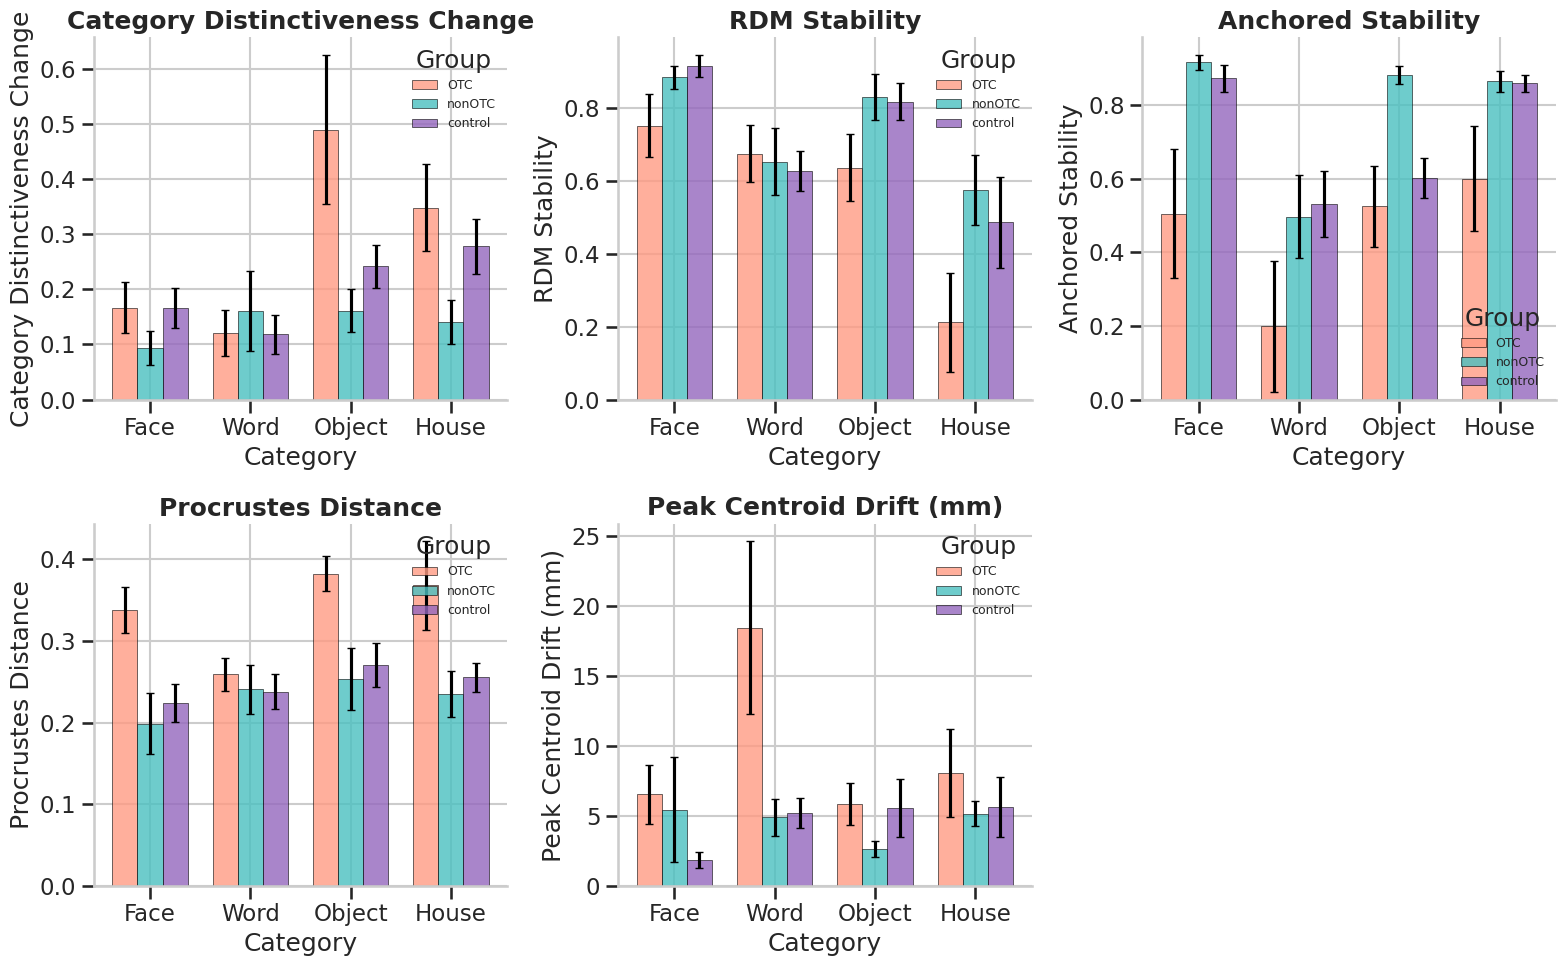

✓ Saved fig1_all_measures_by_category.png


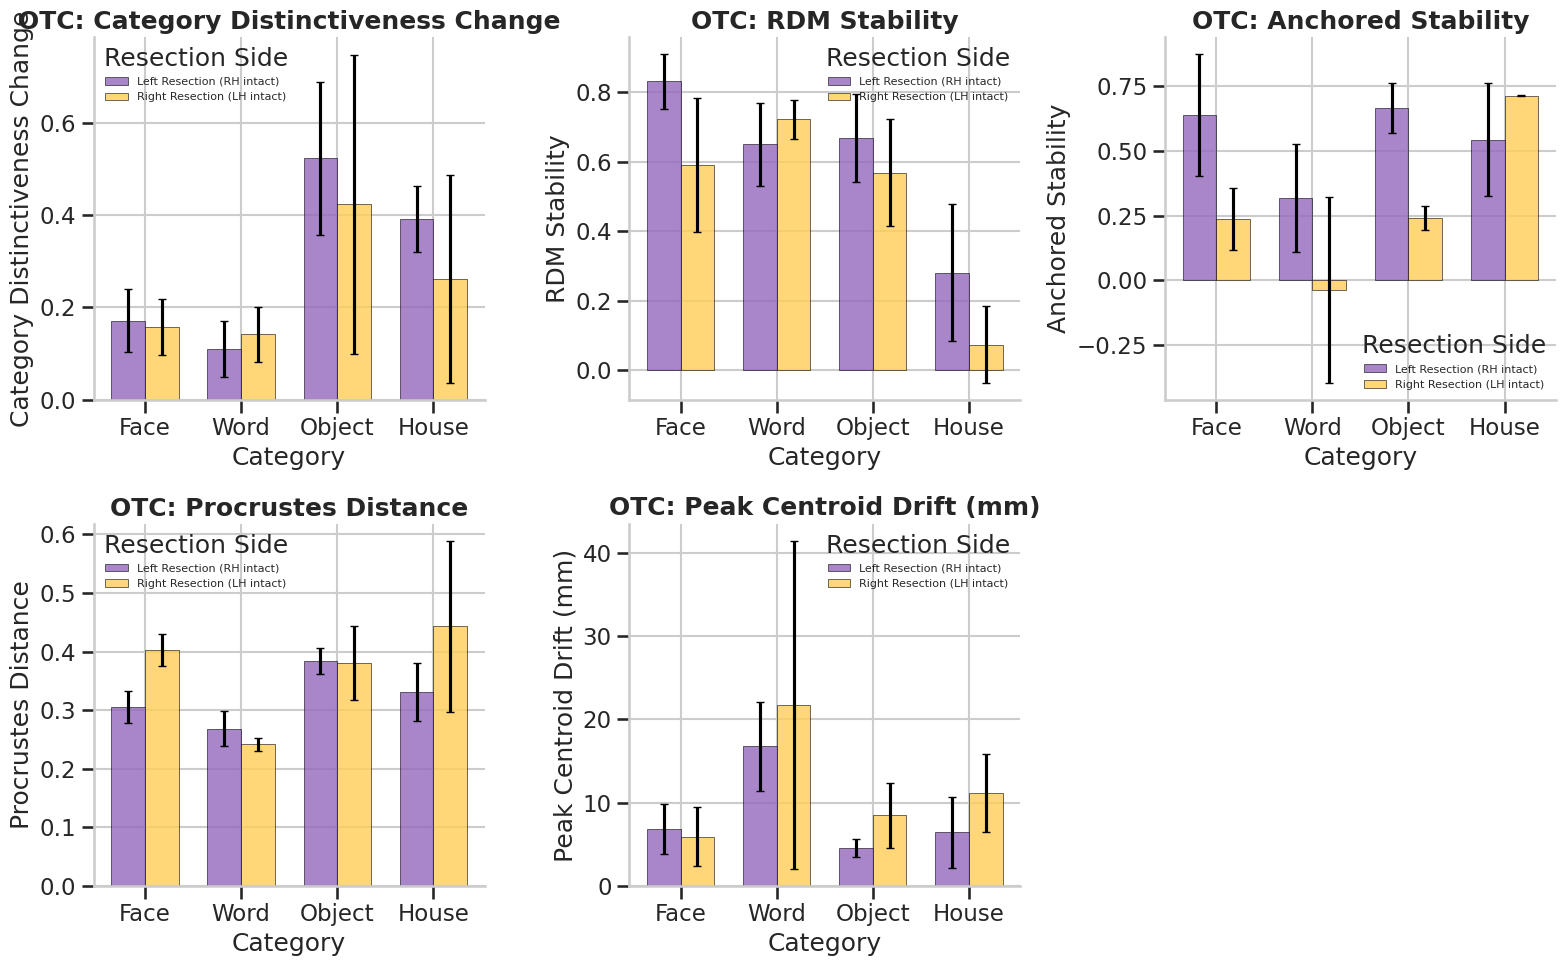

✓ Saved fig2_otc_by_hemisphere.png


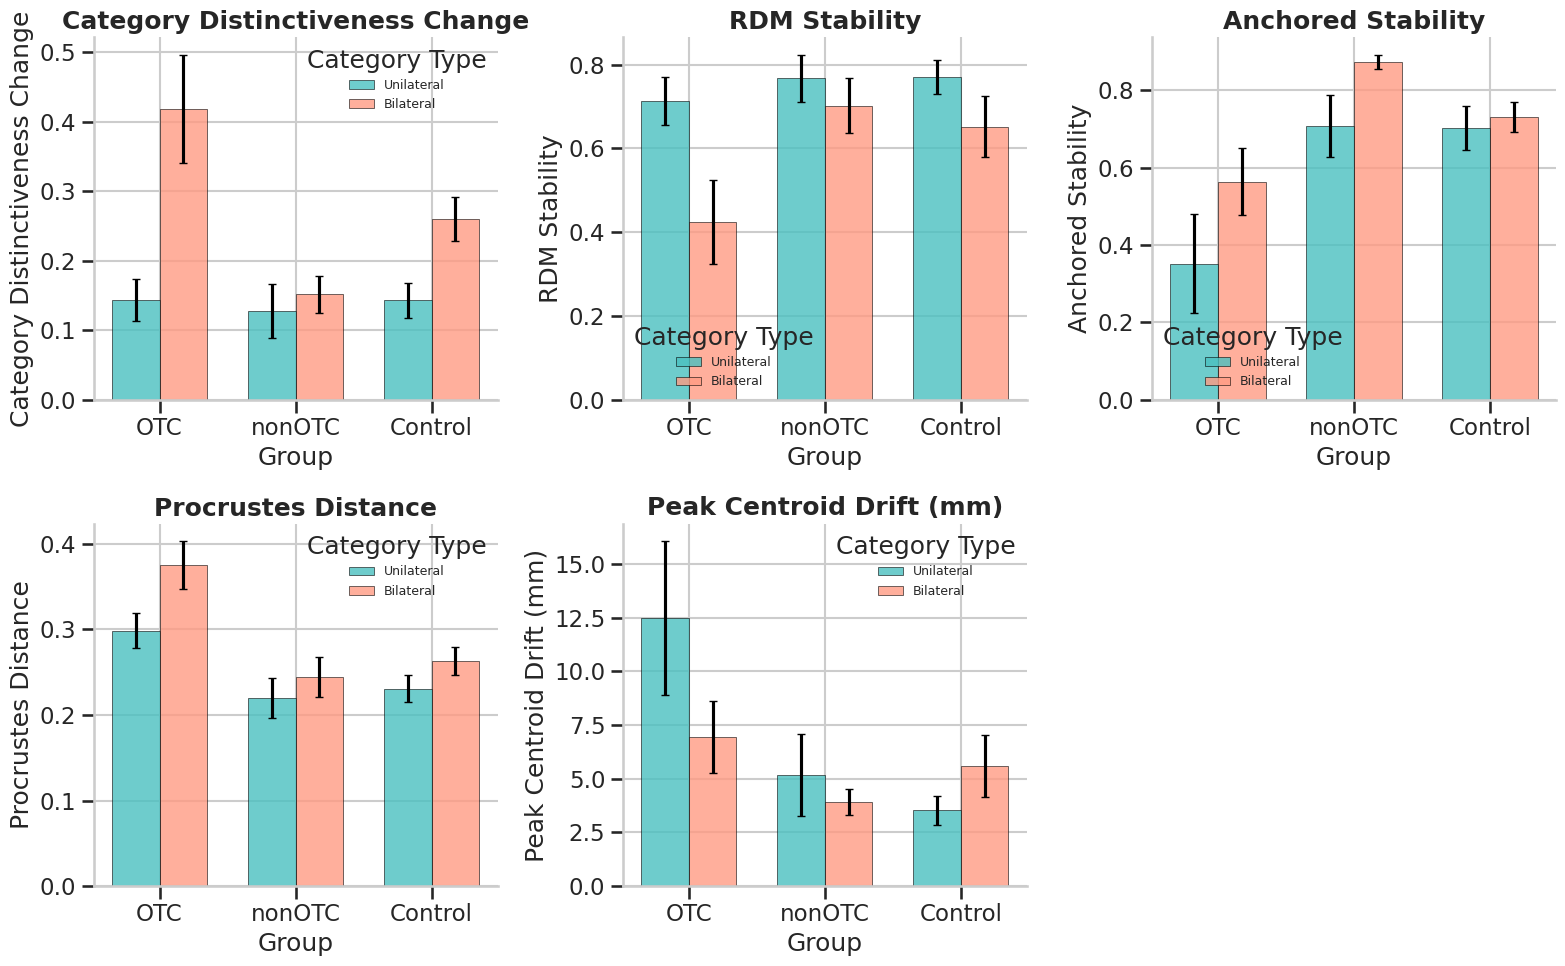

✓ Saved fig3_bilateral_vs_unilateral.png


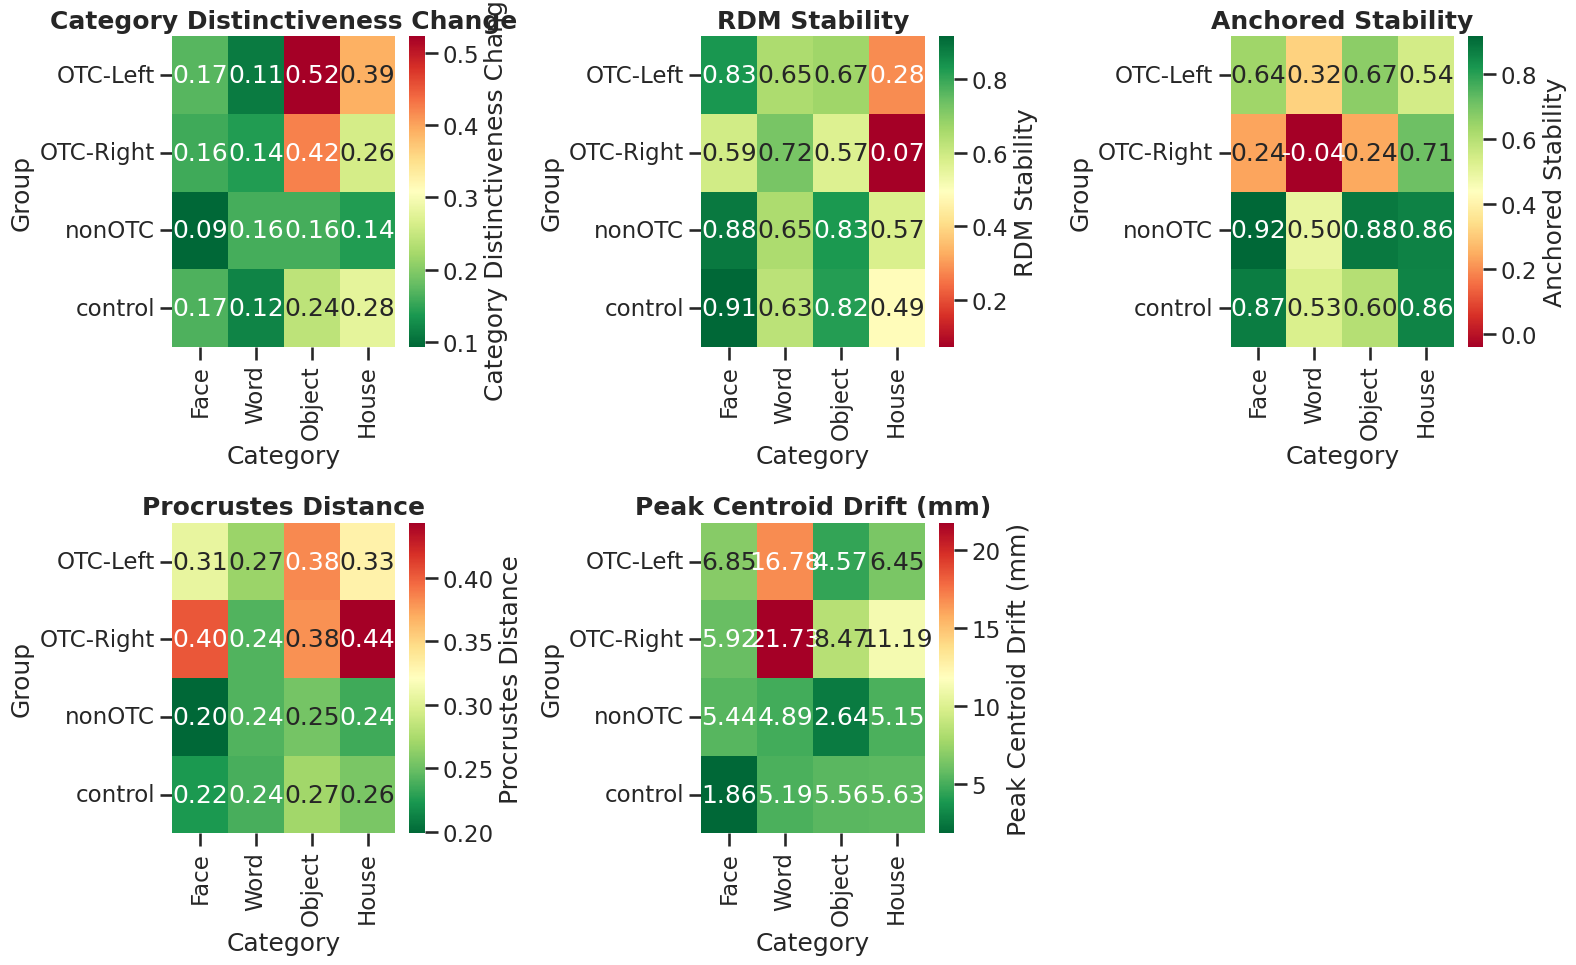

✓ Saved fig4_heatmaps.png


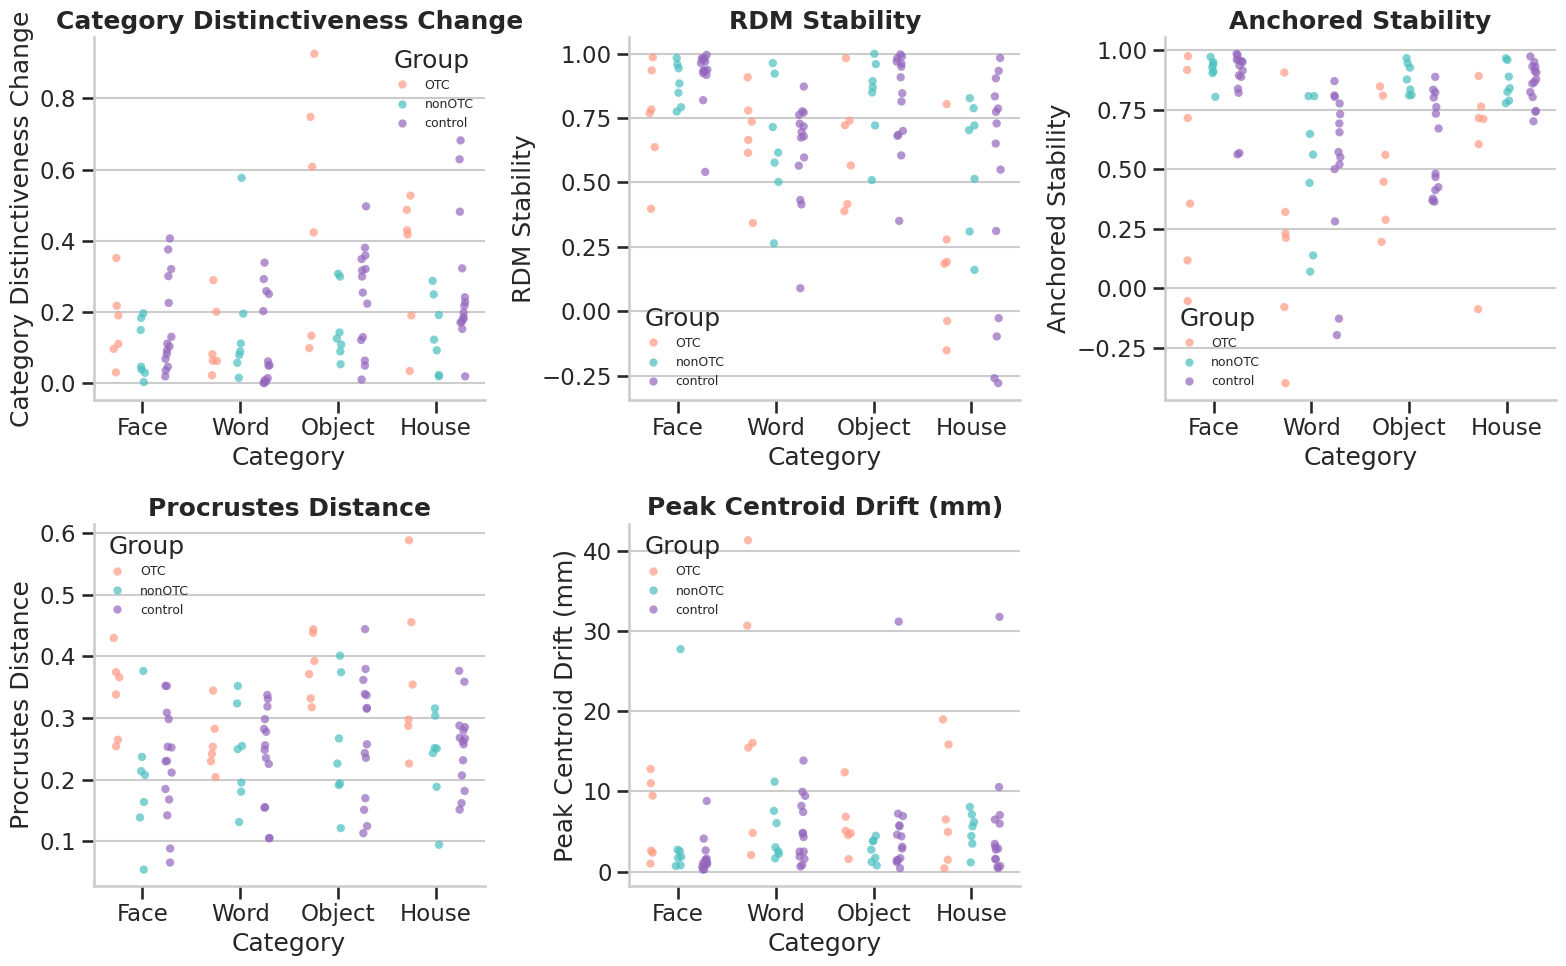

✓ Saved fig5_individual_subjects.png


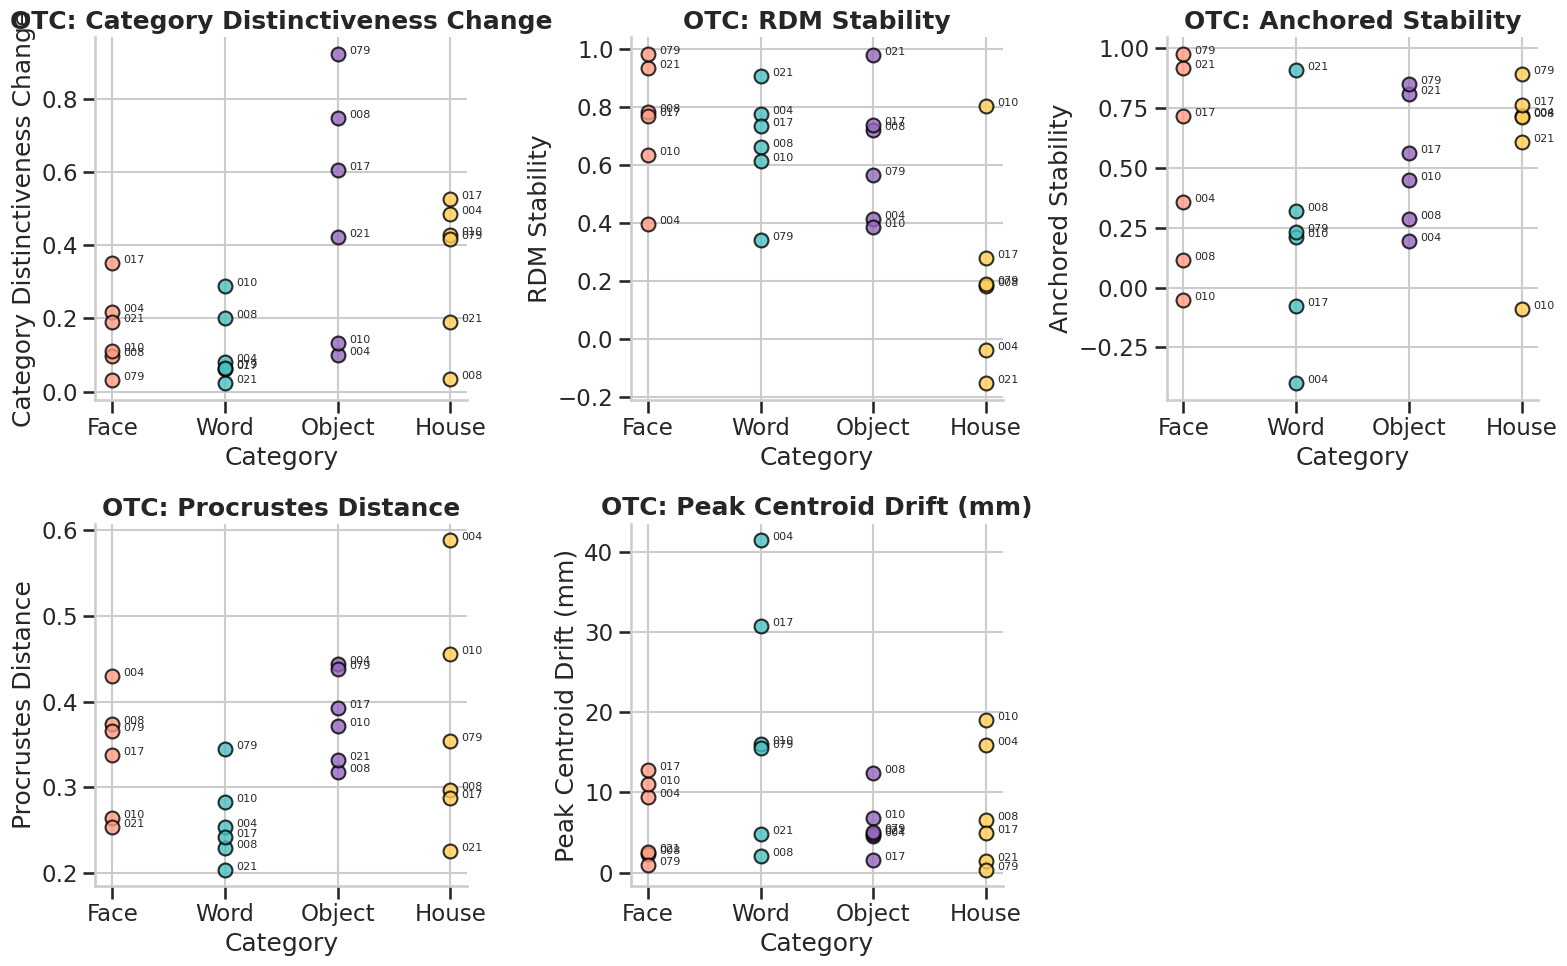

✓ Saved fig6_otc_individual_labeled.png


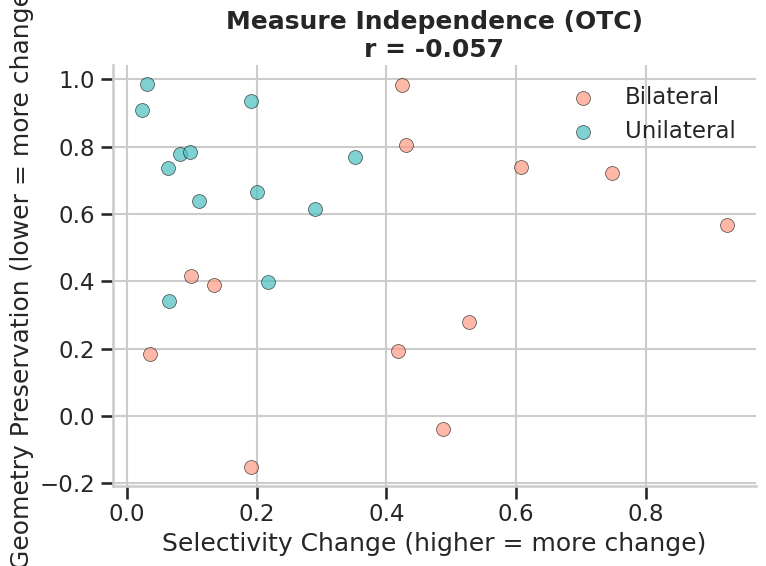

✓ Saved fig7_measure_independence.png

ALL FIGURES SAVED TO: /user_data/csimmon2/git_repos/long_pt/B_analyses/figures


In [3]:
# Cell: Merged Figure Generation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Setup
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
FIGURE_DIR = '/user_data/csimmon2/git_repos/long_pt/B_analyses/figures'
os.makedirs(FIGURE_DIR, exist_ok=True)

# Load and filter data
df = pd.read_csv('/user_data/csimmon2/git_repos/long_pt/results_final_corrected.csv')
exclude = ['control025', 'control027', 'nonOTC045', 'nonOTC072']
df = df[~df['Subject'].isin(exclude)]

# Add category type
df['Category_Type'] = df['Category'].map({
    'Face': 'Unilateral', 'Word': 'Unilateral',
    'Object': 'Bilateral', 'House': 'Bilateral'
})

# Pastel colors
group_colors = {'OTC': '#ff9b83', 'nonOTC': '#4ac0c0', 'control': '#9467bd'}
category_colors = {'Face': '#ff9b83', 'Word': '#4ac0c0', 'Object': '#9467bd', 'House': '#ffce56'}
type_colors = {'Bilateral': '#ff9b83', 'Unilateral': '#4ac0c0'}
resection_colors = {'Left Resection (RH intact)': '#9467bd', 'Right Resection (LH intact)': '#ffce56'}

# Orders
category_order = ['Face', 'Word', 'Object', 'House']
group_order = ['OTC', 'nonOTC', 'control']

# 5 Measures
measures = {
    'Selectivity_Change': 'Category Distinctiveness Change',
    'Geometry_Preservation_6mm': 'RDM Stability',
    'Anchored_Stability_6mm': 'Anchored Stability',
    'MDS_Shift': 'Procrustes Distance',
    'Spatial_Relocation_mm': 'Peak Centroid Drift (mm)'
}

print(f"Total observations: {len(df)}")
print(f"Subjects per group:\n{df.groupby('Group')['Subject'].nunique()}")

# ============================================================
# FIGURE 1: Bar plots by category (All Groups)
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (measure_col, measure_name) in enumerate(measures.items()):
    ax = axes[idx]
    
    summary = df.groupby(['Group', 'Category'])[measure_col].agg(['mean', 'sem']).reset_index()
    summary['Group'] = pd.Categorical(summary['Group'], categories=group_order, ordered=True)
    summary['Category'] = pd.Categorical(summary['Category'], categories=category_order, ordered=True)
    summary = summary.sort_values(['Category', 'Group'])
    
    x = np.arange(len(category_order))
    width = 0.25
    
    for i, group in enumerate(group_order):
        group_data = summary[summary['Group'] == group]
        ax.bar(x + i*width, group_data['mean'], width, 
               label=group, color=group_colors[group], 
               yerr=group_data['sem'], capsize=3, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel('Category')
    ax.set_ylabel(measure_name)
    ax.set_title(measure_name, fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(category_order)
    ax.legend(title='Group', fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Hide empty subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/fig1_all_measures_by_category.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved fig1_all_measures_by_category.png")

# ============================================================
# FIGURE 2: OTC Hemisphere Breakdown
# ============================================================
otc_df = df[df['Group'] == 'OTC'].copy()
otc_df['Resection'] = otc_df['Surgery_Side'].map({
    'left': 'Left Resection (RH intact)', 
    'right': 'Right Resection (LH intact)'
})
resection_order = ['Left Resection (RH intact)', 'Right Resection (LH intact)']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (measure_col, measure_name) in enumerate(measures.items()):
    ax = axes[idx]
    
    summary = otc_df.groupby(['Resection', 'Category'])[measure_col].agg(['mean', 'sem']).reset_index()
    summary['Category'] = pd.Categorical(summary['Category'], categories=category_order, ordered=True)
    summary = summary.sort_values(['Category', 'Resection'])
    
    x = np.arange(len(category_order))
    width = 0.35
    
    for i, resection in enumerate(resection_order):
        res_data = summary[summary['Resection'] == resection]
        if len(res_data) > 0:
            ax.bar(x + i*width, res_data['mean'], width,
                   label=resection, color=resection_colors[resection],
                   yerr=res_data['sem'], capsize=3, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel('Category')
    ax.set_ylabel(measure_name)
    ax.set_title(f'OTC: {measure_name}', fontweight='bold')
    ax.set_xticks(x + width/2)
    ax.set_xticklabels(category_order)
    ax.legend(title='Resection Side', fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[5].axis('off')

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/fig2_otc_by_hemisphere.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved fig2_otc_by_hemisphere.png")

# ============================================================
# FIGURE 3: Bilateral vs Unilateral Summary
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()
type_order = ['Unilateral', 'Bilateral']

for idx, (measure_col, measure_name) in enumerate(measures.items()):
    ax = axes[idx]
    
    summary = df.groupby(['Group', 'Category_Type'])[measure_col].agg(['mean', 'sem']).reset_index()
    summary['Group'] = pd.Categorical(summary['Group'], categories=group_order, ordered=True)
    summary = summary.sort_values(['Group', 'Category_Type'])
    
    x = np.arange(len(group_order))
    width = 0.35
    
    for i, cat_type in enumerate(type_order):
        type_data = summary[summary['Category_Type'] == cat_type]
        ax.bar(x + i*width, type_data['mean'], width,
               label=cat_type, color=type_colors[cat_type],
               yerr=type_data['sem'], capsize=3, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel('Group')
    ax.set_ylabel(measure_name)
    ax.set_title(measure_name, fontweight='bold')
    ax.set_xticks(x + width/2)
    ax.set_xticklabels(['OTC', 'nonOTC', 'Control'])
    ax.legend(title='Category Type', fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[5].axis('off')

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/fig3_bilateral_vs_unilateral.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved fig3_bilateral_vs_unilateral.png")

# ============================================================
# FIGURE 4: Heatmaps (OTC split by hemisphere)
# ============================================================
# Create hemisphere-split group column
df_heat = df.copy()
df_heat['Group_Hemi'] = df_heat['Group']

# Split OTC by hemisphere
otc_mask = df_heat['Group'] == 'OTC'
df_heat.loc[otc_mask & (df_heat['Surgery_Side'] == 'left'), 'Group_Hemi'] = 'OTC-Left'
df_heat.loc[otc_mask & (df_heat['Surgery_Side'] == 'right'), 'Group_Hemi'] = 'OTC-Right'

heatmap_order = ['OTC-Left', 'OTC-Right', 'nonOTC', 'control']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (measure_col, measure_name) in enumerate(measures.items()):
    ax = axes[idx]
    
    pivot = df_heat.pivot_table(values=measure_col, index='Group_Hemi', columns='Category', aggfunc='mean')
    pivot = pivot.reindex(index=heatmap_order, columns=category_order)
    
    # Colormap: RDM Stability & Anchored Stability higher=better (green), others higher=more change (red)
    if measure_col in ['Geometry_Preservation_6mm', 'Anchored_Stability_6mm']:
        cmap = 'RdYlGn'
    else:
        cmap = 'RdYlGn_r'
    
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap=cmap, ax=ax,
                cbar_kws={'label': measure_name})
    
    ax.set_title(measure_name, fontweight='bold')
    ax.set_xlabel('Category')
    ax.set_ylabel('Group')

axes[5].axis('off')

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/fig4_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved fig4_heatmaps.png")

# ============================================================
# FIGURE 5: Individual Subject Strip Plots
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (measure_col, measure_name) in enumerate(measures.items()):
    ax = axes[idx]
    
    plot_df = df.copy()
    plot_df['Group'] = pd.Categorical(plot_df['Group'], categories=group_order, ordered=True)
    plot_df['Category'] = pd.Categorical(plot_df['Category'], categories=category_order, ordered=True)
    
    sns.stripplot(data=plot_df, x='Category', y=measure_col, hue='Group',
                  palette=group_colors, dodge=True, alpha=0.7, ax=ax, size=6)
    
    ax.set_xlabel('Category')
    ax.set_ylabel(measure_name)
    ax.set_title(measure_name, fontweight='bold')
    ax.legend(title='Group', fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[5].axis('off')

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/fig5_individual_subjects.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved fig5_individual_subjects.png")

# ============================================================
# FIGURE 6: OTC Individual Subjects Labeled
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (measure_col, measure_name) in enumerate(measures.items()):
    ax = axes[idx]
    
    for i, cat in enumerate(category_order):
        cat_data = otc_df[otc_df['Category'] == cat]
        y_vals = cat_data[measure_col].values
        x_vals = [i] * len(y_vals)
        
        ax.scatter(x_vals, y_vals, c=category_colors[cat], s=100, alpha=0.8, edgecolors='black')
        
        for j, (x, y, subj) in enumerate(zip(x_vals, y_vals, cat_data['Subject'])):
            ax.annotate(subj.replace('OTC', ''), (x + 0.1, y), fontsize=8)
    
    ax.set_xticks(range(len(category_order)))
    ax.set_xticklabels(category_order)
    ax.set_xlabel('Category')
    ax.set_ylabel(measure_name)
    ax.set_title(f'OTC: {measure_name}', fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[5].axis('off')

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/fig6_otc_individual_labeled.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved fig6_otc_individual_labeled.png")

# ============================================================
# FIGURE 7: Measure Independence (Selectivity vs Geometry)
# ============================================================
fig, ax = plt.subplots(figsize=(8, 6))

otc_only = df[df['Group'] == 'OTC']
for cat_type in ['Bilateral', 'Unilateral']:
    subset = otc_only[otc_only['Category_Type'] == cat_type]
    ax.scatter(subset['Selectivity_Change'], subset['Geometry_Preservation_6mm'], 
               label=cat_type, color=type_colors[cat_type], s=100, alpha=0.7, 
               edgecolor='black', linewidth=0.5)

corr_all = otc_only['Selectivity_Change'].corr(otc_only['Geometry_Preservation_6mm'])

ax.set_xlabel('Selectivity Change (higher = more change)')
ax.set_ylabel('Geometry Preservation (lower = more change)')
ax.set_title(f'Measure Independence (OTC)\nr = {corr_all:.3f}', fontweight='bold')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(f'{FIGURE_DIR}/fig7_measure_independence.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved fig7_measure_independence.png")

print("\n" + "="*50)
print("ALL FIGURES SAVED TO:", FIGURE_DIR)
print("="*50)

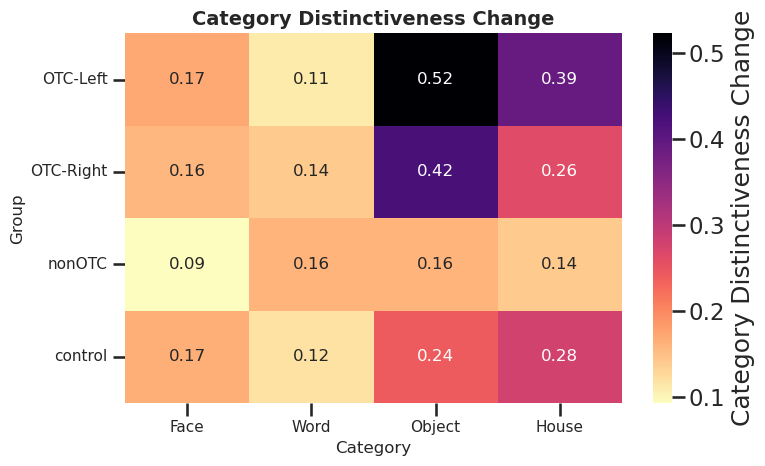

✓ Saved fig4_Selectivity_Change_heatmap.png


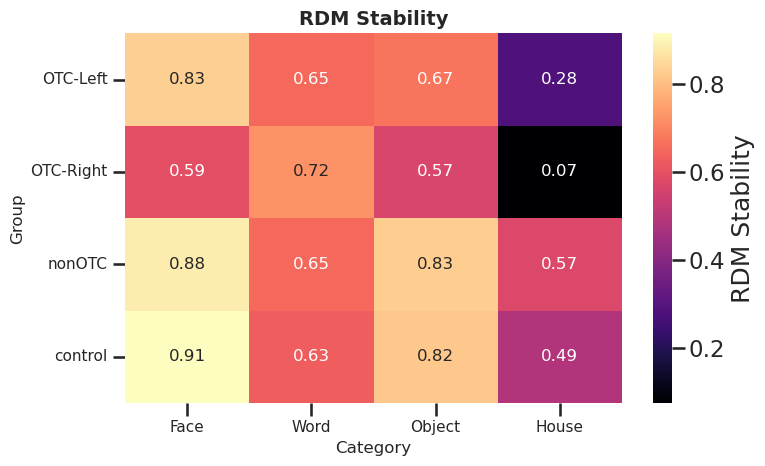

✓ Saved fig4_Geometry_Preservation_6mm_heatmap.png


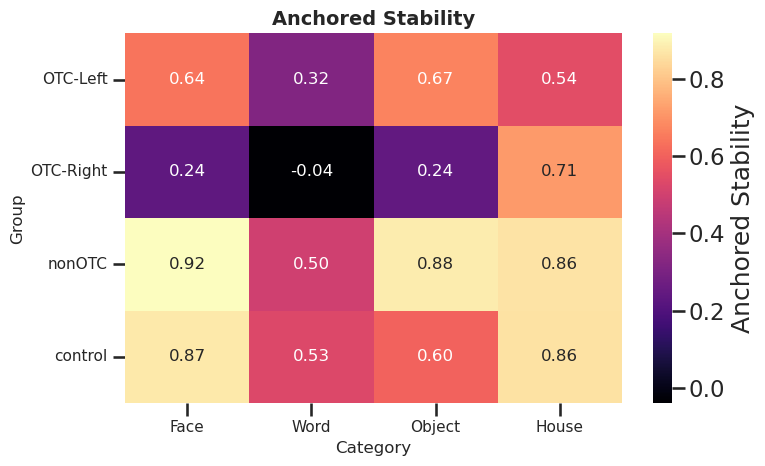

✓ Saved fig4_Anchored_Stability_6mm_heatmap.png


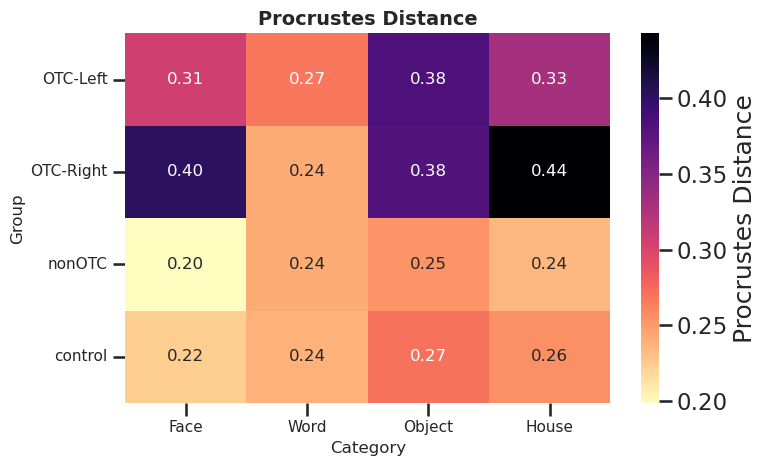

✓ Saved fig4_MDS_Shift_heatmap.png


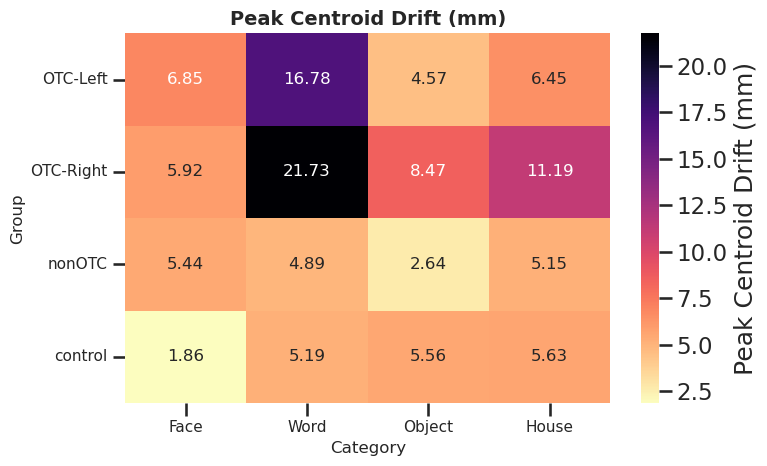

✓ Saved fig4_Spatial_Relocation_mm_heatmap.png


In [4]:
# ============================================================
# FIGURE 4: Heatmaps (OTC split by hemisphere) - Individual figures
# ============================================================

# Create hemisphere-split group column
df_heat = df.copy()
df_heat['Group_Hemi'] = df_heat['Group']

# Split OTC by hemisphere
otc_mask = df_heat['Group'] == 'OTC'
df_heat.loc[otc_mask & (df_heat['Surgery_Side'] == 'left'), 'Group_Hemi'] = 'OTC-Left'
df_heat.loc[otc_mask & (df_heat['Surgery_Side'] == 'right'), 'Group_Hemi'] = 'OTC-Right'

heatmap_order = ['OTC-Left', 'OTC-Right', 'nonOTC', 'control']

for idx, (measure_col, measure_name) in enumerate(measures.items()):
    fig, ax = plt.subplots(figsize=(8, 5))
    
    pivot = df_heat.pivot_table(values=measure_col, index='Group_Hemi', columns='Category', aggfunc='mean')
    pivot = pivot.reindex(index=heatmap_order, columns=category_order)
    
    # Flip colormap: stability measures (higher=better) use magma, others use magma_r
    if measure_col in ['Geometry_Preservation_6mm', 'Anchored_Stability_6mm']:
        cmap = 'magma'
    else:
        cmap = 'magma_r'
    
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap=cmap, ax=ax,
                annot_kws={'size': 12}, cbar_kws={'label': measure_name})
    
    ax.set_title(measure_name, fontsize=14, fontweight='bold')
    ax.set_xlabel('Category', fontsize=12)
    ax.set_ylabel('Group', fontsize=12)
    ax.tick_params(labelsize=11)
    
    plt.tight_layout()
    plt.savefig(f'{FIGURE_DIR}/fig4_{measure_col}_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved fig4_{measure_col}_heatmap.png")

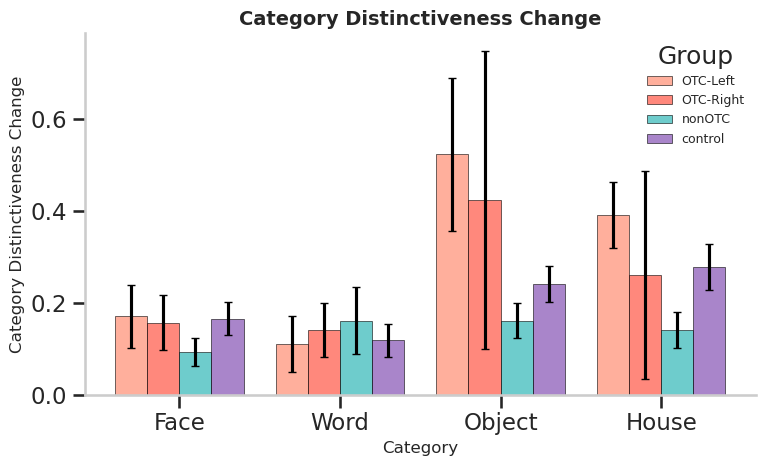

✓ Saved fig1_Selectivity_Change_by_category.png


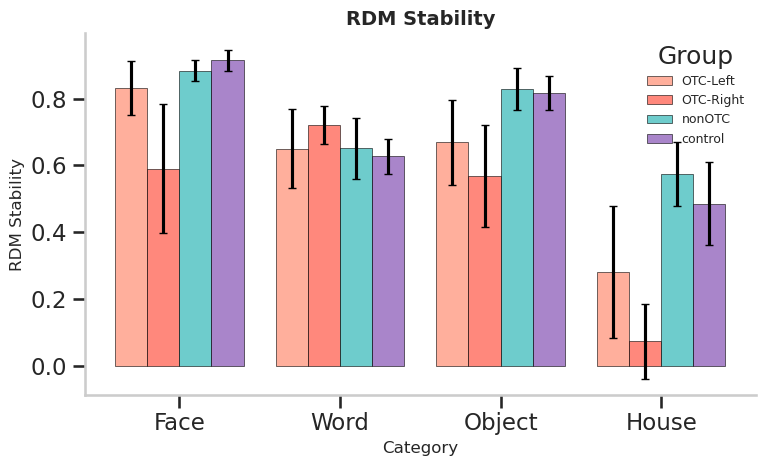

✓ Saved fig1_Geometry_Preservation_6mm_by_category.png


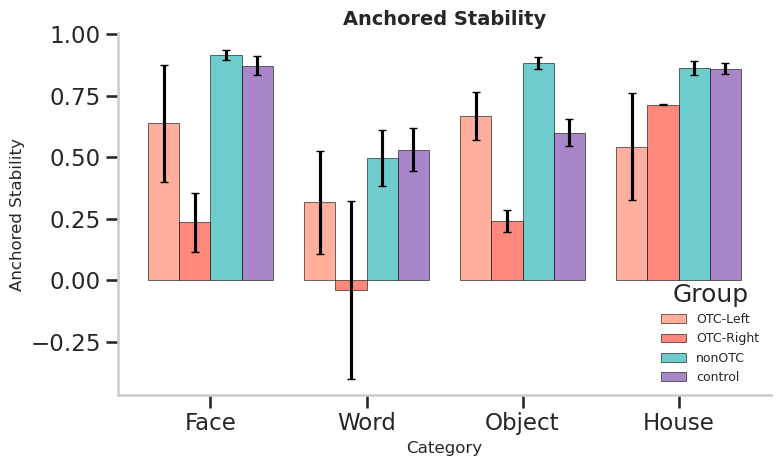

✓ Saved fig1_Anchored_Stability_6mm_by_category.png


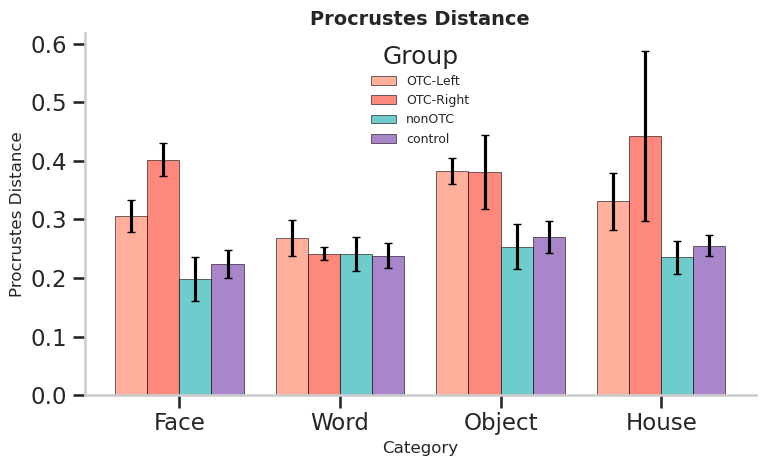

✓ Saved fig1_MDS_Shift_by_category.png


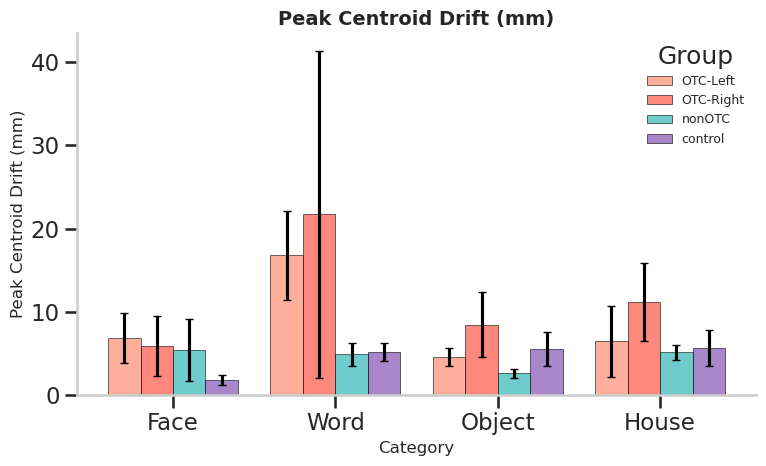

✓ Saved fig1_Spatial_Relocation_mm_by_category.png


In [5]:
# ============================================================
# FIGURE 1: Bar plots by category (OTC split by hemisphere) - Individual figures
# ============================================================

# Group order now includes OTC split
group_order_split = ['OTC-Left', 'OTC-Right', 'nonOTC', 'control']
group_colors_split = {
    'OTC-Left': '#ff9b83',      # Salmon
    'OTC-Right': '#ff6b5b',     # Slightly darker salmon
    'nonOTC': '#4ac0c0', 
    'control': '#9467bd'
}

# Create split group column
df_split = df.copy()
df_split['Group_Split'] = df_split['Group']
otc_mask = df_split['Group'] == 'OTC'
df_split.loc[otc_mask & (df_split['Surgery_Side'] == 'left'), 'Group_Split'] = 'OTC-Left'
df_split.loc[otc_mask & (df_split['Surgery_Side'] == 'right'), 'Group_Split'] = 'OTC-Right'

for measure_col, measure_name in measures.items():
    fig, ax = plt.subplots(figsize=(8, 5))
    
    summary = df_split.groupby(['Group_Split', 'Category'])[measure_col].agg(['mean', 'sem']).reset_index()
    summary['Group_Split'] = pd.Categorical(summary['Group_Split'], categories=group_order_split, ordered=True)
    summary['Category'] = pd.Categorical(summary['Category'], categories=category_order, ordered=True)
    summary = summary.sort_values(['Category', 'Group_Split'])
    
    x = np.arange(len(category_order))
    width = 0.2
    
    for i, group in enumerate(group_order_split):
        group_data = summary[summary['Group_Split'] == group]
        ax.bar(x + i*width, group_data['mean'], width, 
               label=group, color=group_colors_split[group], 
               yerr=group_data['sem'], capsize=3, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax.set_xlabel('Category', fontsize=12)
    ax.set_ylabel(measure_name, fontsize=12)
    ax.set_title(measure_name, fontsize=14, fontweight='bold')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(category_order)
    ax.legend(title='Group', fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)  # Remove grid
    
    plt.tight_layout()
    plt.savefig(f'{FIGURE_DIR}/fig1_{measure_col}_by_category.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved fig1_{measure_col}_by_category.png")